# Investigating Vix Levels And Returns

## Python Imports

In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MultipleLocator
import warnings
import seaborn as sns
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random
warnings.filterwarnings("ignore")

## Python Functions

In [2]:
# This function pulls data from Yahoo finance
import pandas as pd
import numpy as np
import yfinance as yf

def yf_data_updater(fund):
    # Download data from YF
    df_comp = yf.download(fund)
    
    # Reset index
    df_comp.reset_index(inplace = True)
    
    # Drop data from last day because it's not accrate until end of day
    df_comp.drop(df_comp.index[-1], inplace=True)
    
    # Reset date column
    df_comp['Date'] = df_comp['Date'].dt.tz_localize(None)
    
    # Set index to date
    df_comp.set_index('Date', inplace = True)
    
    # Export data to excel
    file = fund + ".xlsx"
    df_comp.to_excel(file, sheet_name='data')

    print(f"The last date of data for {fund} is: ")
    print(df_comp[-1:])
    print(f"Data updater complete for {fund} data")
    return print(f"--------------------")

In [3]:
yf_data_updater('^VIX')

[*********************100%***********************]  1 of 1 completed


The last date of data for ^VIX is: 
                 Open       High    Low      Close  Adj Close  Volume
Date                                                                 
2024-10-28  19.110001  19.879999  18.91  19.799999  19.799999       0
Data updater complete for ^VIX data
--------------------


In [4]:
# Set number of decimal places in pandas
def dp(decimal_places):
    pd.set_option('display.float_format', lambda x: f'%.{decimal_places}f' % x)

dp(2)

In [5]:
def load_data(file):
    # Import CSV
    try:
        df = pd.read_csv(file)
    except:
        pass

    # Import excel
    try:
        df = pd.read_excel(file, sheet_name='data', engine='openpyxl')
    except:
        pass
        
    return df

In [6]:
# The `df_info` function returns some useful information about a dataframe, such as the columns, data types, and size.
def df_info(df):
    print('There are ', df.shape[0], ' rows and ', df.shape[1], ' columns')
    print('The columns and data types are:')
    print(df.dtypes)
    print('The first 4 rows are:')
    display(df.head(4))
    print('The last 4 rows are:')
    display(df.tail(4))

## Import Data

### CBOE Volatility Index (VIX)

In [7]:
# VIX
vix = load_data('^VIX.xlsx')

# Set 'Date' column as datetime
vix['Date'] = pd.to_datetime(vix['Date'])

# Drop 'Volume' and 'Adj Close'
vix.drop(columns = {'Adj Close', 'Volume'}, inplace = True)

# Set Date as index
vix.set_index('Date', inplace = True)

In [8]:
# Check to see if there are any NaN values
vix[vix['High'].isna()]

# Forward fill to clean up missing data
vix['High'].ffill(inplace = True)

In [9]:
df_info(vix)

There are  8773  rows and  4  columns
The columns and data types are:
Open     float64
High     float64
Low      float64
Close    float64
dtype: object
The first 4 rows are:


,Open,High,Low,Close
Date,,,,
1990-01-02,17.24,17.24,17.24,17.24
1990-01-03,18.19,18.19,18.19,18.19
1990-01-04,19.22,19.22,19.22,19.22
1990-01-05,20.11,20.11,20.11,20.11


The last 4 rows are:


,Open,High,Low,Close
Date,,,,
2024-10-23,18.21,20.47,18.18,19.24
2024-10-24,18.87,20.24,18.63,19.08
2024-10-25,19.22,20.51,18.23,20.33
2024-10-28,19.11,19.88,18.91,19.80


In [10]:
vix_stats = vix.describe()

In [11]:
vix_stats.loc['mean + 1 std'] = {'Open': vix_stats.loc['mean']['Open'] + vix_stats.loc['std']['Open'],
                                 'High': vix_stats.loc['mean']['High'] + vix_stats.loc['std']['High'],
                                 'Low': vix_stats.loc['mean']['Low'] + vix_stats.loc['std']['Low'],
                                 'Close': vix_stats.loc['mean']['Close'] + vix_stats.loc['std']['Close']}
vix_stats.loc['mean + 2 std'] = {'Open': vix_stats.loc['mean']['Open'] + 2 * vix_stats.loc['std']['Open'],
                                 'High': vix_stats.loc['mean']['High'] + 2 * vix_stats.loc['std']['High'],
                                 'Low': vix_stats.loc['mean']['Low'] + 2 * vix_stats.loc['std']['Low'],
                                 'Close': vix_stats.loc['mean']['Close'] + 2 * vix_stats.loc['std']['Close']}
vix_stats.loc['mean - 1 std'] = {'Open': vix_stats.loc['mean']['Open'] - vix_stats.loc['std']['Open'],
                                 'High': vix_stats.loc['mean']['High'] - vix_stats.loc['std']['High'],
                                 'Low': vix_stats.loc['mean']['Low'] - vix_stats.loc['std']['Low'],
                                 'Close': vix_stats.loc['mean']['Close'] - vix_stats.loc['std']['Close']}

In [12]:
vix_stats

,Open,High,Low,Close
count,8773.00,8773.00,8773.00,8773.00
mean,19.58,20.38,18.82,19.49
std,7.93,8.40,7.42,7.86
min,9.01,9.31,8.56,9.14
25%,13.90,14.48,13.38,13.83
50%,17.68,18.33,17.07,17.64
75%,22.99,23.83,22.18,22.85
max,82.69,89.53,72.76,82.69
mean + 1 std,27.51,28.78,26.24,27.34
mean + 2 std,35.43,37.18,33.67,35.20


In [13]:
deciles = vix.quantile(np.arange(0, 1.1, 0.1))
display(deciles)

,Open,High,Low,Close
0.00,9.01,9.31,8.56,9.14
0.10,12.12,12.61,11.70,12.10
0.20,13.26,13.84,12.81,13.22
0.30,14.61,15.25,14.03,14.55
0.40,16.11,16.74,15.54,16.08
0.50,17.68,18.33,17.07,17.64
0.60,19.69,20.38,19.02,19.56
0.70,21.79,22.64,21.01,21.64
0.80,24.40,25.36,23.53,24.32
0.90,28.88,30.00,27.80,28.72


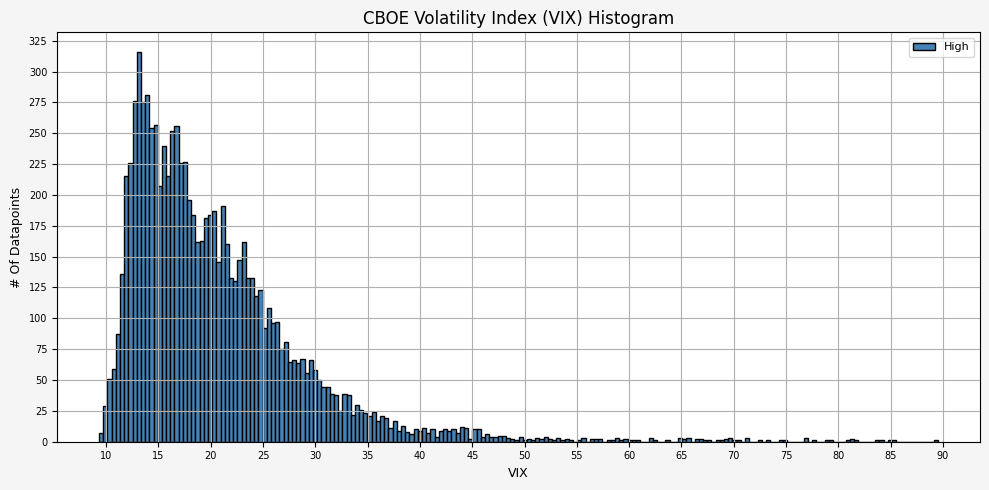

In [14]:
# Plotting the VIX
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

plt.hist([vix['High']], 
         label=['High'], bins=200, edgecolor='black', color='steelblue')

# Set X axis
x_tick_spacing = 5  # Specify the interval for y-axis ticks
plt.gca().xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
plt.xlabel('VIX', fontsize = 9)
plt.xticks(rotation = 0, fontsize = 7)

# Set Y axis
y_tick_spacing = 25  # Specify the interval for y-axis ticks
plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
plt.ylabel('# Of Datapoints', fontsize = 9)
plt.yticks(fontsize = 7)

# Set title, etc.
plt.title('CBOE Volatility Index (VIX) Histogram', fontsize = 12)

# Set the grid & legend
plt.tight_layout()
plt.grid(True)
plt.legend(fontsize=8)

# Save the figure
plt.savefig('04_Histogram.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

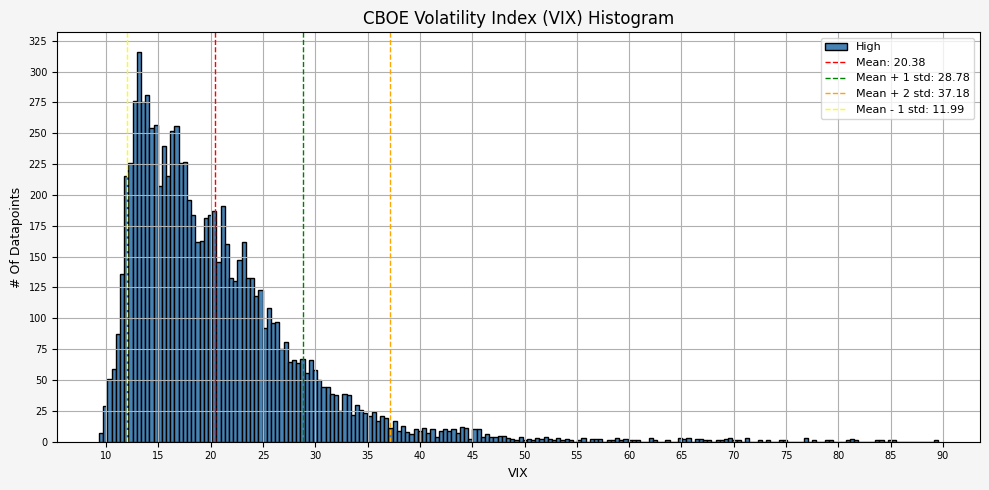

In [15]:
# Plotting the VIX
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

plt.hist([vix['High']], 
         label=['High'], bins=200, edgecolor='black', color='steelblue')

# Plot a vertical line at the mean, mean + 1 std, and mean + 2 std
plt.axvline(vix_stats.loc['mean']['High'], color='red', linestyle='dashed', linewidth=1, label=f'Mean: {vix_stats.loc['mean']['High']:.2f}')
plt.axvline(vix_stats.loc['mean + 1 std']['High'], color='green', linestyle='dashed', linewidth=1, label=f'Mean + 1 std: {vix_stats.loc['mean + 1 std']['High']:.2f}')
plt.axvline(vix_stats.loc['mean + 2 std']['High'], color='orange', linestyle='dashed', linewidth=1, label=f'Mean + 2 std: {vix_stats.loc['mean + 2 std']['High']:.2f}')
plt.axvline(vix_stats.loc['mean - 1 std']['High'], color='yellow', linestyle='dashed', linewidth=1, label=f'Mean - 1 std: {vix_stats.loc['mean - 1 std']['High']:.2f}')

# Set X axis
x_tick_spacing = 5  # Specify the interval for y-axis ticks
plt.gca().xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
plt.xlabel('VIX', fontsize = 9)
plt.xticks(rotation = 0, fontsize = 7)

# Set Y axis
y_tick_spacing = 25  # Specify the interval for y-axis ticks
plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
plt.ylabel('# Of Datapoints', fontsize = 9)
plt.yticks(fontsize = 7)

# Set title, etc.
plt.title('CBOE Volatility Index (VIX) Histogram', fontsize = 12)

# Set the grid & legend
plt.tight_layout()
plt.grid(True)
plt.legend(fontsize=8)

# Save the figure
plt.savefig('05_Histogram+Mean.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## Plots

### CBOE Volatility Index (VIX)

#### 1990 - 2009

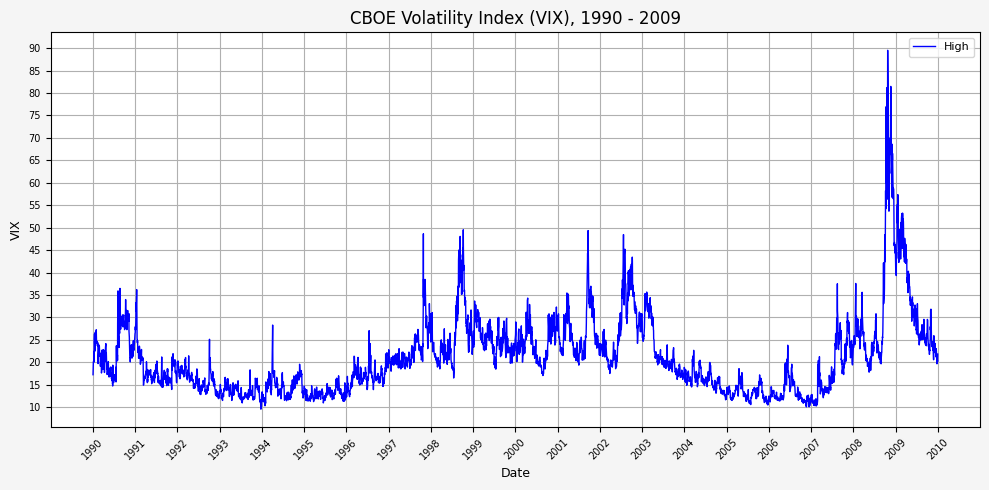

In [16]:
# Plotting the VIX
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

plt.plot(vix[vix.index <= '2009-12-31'].index, vix[vix.index <= '2009-12-31']['High'], label='High', linestyle='-', color='b', linewidth=1)
# plt.plot(vix.index, vix['SMA_10'], label='10 Day SMA', linestyle='-', color='r', linewidth=1)
# plt.plot(vix.index, vix['SMA_20'], label='20 Day SMA', linestyle='-', color='orange', linewidth=1)
# plt.plot(vix.index, vix['SMA_50'], label='50 Day SMA', linestyle='-', color='g', linewidth=1)

# Set X axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Date', fontsize = 9)
plt.xticks(rotation = 45, fontsize = 7)

# Set Y axis
y_tick_spacing = 5  # Specify the interval for y-axis ticks
plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
plt.ylabel('VIX', fontsize = 9)
plt.yticks(fontsize = 7)

# Set title, etc.
plt.title('CBOE Volatility Index (VIX), 1990 - 2009', fontsize = 12)

# Set the grid & legend
plt.tight_layout()
plt.grid(True)
plt.legend(fontsize=8)

# Save the figure
plt.savefig('06_Plot_1990-2009.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

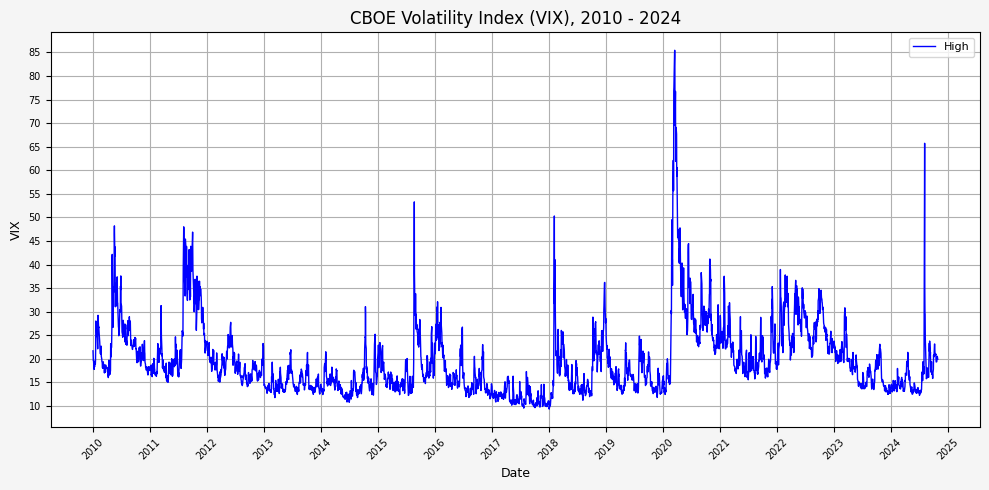

In [17]:
# Plotting the VIX
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

plt.plot(vix[vix.index > '2009-12-31'].index, vix[vix.index > '2009-12-31']['High'], label='High', linestyle='-', color='b', linewidth=1)
# plt.plot(vix.index, vix['SMA_10'], label='10 Day SMA', linestyle='-', color='r', linewidth=1)
# plt.plot(vix.index, vix['SMA_20'], label='20 Day SMA', linestyle='-', color='orange', linewidth=1)
# plt.plot(vix.index, vix['SMA_50'], label='50 Day SMA', linestyle='-', color='g', linewidth=1)

# Set X axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Date', fontsize = 9)
plt.xticks(rotation = 45, fontsize = 7)

# Set Y axis
y_tick_spacing = 5  # Specify the interval for y-axis ticks
plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
plt.ylabel('VIX', fontsize = 9)
plt.yticks(fontsize = 7)

# Set title, etc.
plt.title('CBOE Volatility Index (VIX), 2010 - 2024', fontsize = 12)

# Set the grid & legend
plt.tight_layout()
plt.grid(True)
plt.legend(fontsize=8)

# Save the figure
plt.savefig('07_Plot_2010-2024.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## Determining A Spike Level

In [18]:
spike_level = 1.25
vix['SMA_10'] = vix['High'].rolling(10).mean()
vix['SMA_10_Shift'] = vix['SMA_10'].shift(1)
vix['Spike_Level'] = vix['SMA_10_Shift'] * spike_level
vix['Spike'] = vix['High'] >= vix['Spike_Level']
vix['SMA_20'] = vix['High'].rolling(20).mean()
vix['SMA_50'] = vix['High'].rolling(50).mean()

In [19]:
vix.head(60)

,Open,High,Low,Close,SMA_10,SMA_10_Shift,Spike_Level,Spike,SMA_20,SMA_50
Date,,,,,,,,,,
1990-01-02,17.24,17.24,17.24,17.24,NaN,NaN,NaN,False,NaN,NaN
1990-01-03,18.19,18.19,18.19,18.19,NaN,NaN,NaN,False,NaN,NaN
1990-01-04,19.22,19.22,19.22,19.22,NaN,NaN,NaN,False,NaN,NaN
1990-01-05,20.11,20.11,20.11,20.11,NaN,NaN,NaN,False,NaN,NaN
1990-01-08,20.26,20.26,20.26,20.26,NaN,NaN,NaN,False,NaN,NaN
1990-01-09,22.20,22.20,22.20,22.20,NaN,NaN,NaN,False,NaN,NaN
1990-01-10,22.44,22.44,22.44,22.44,NaN,NaN,NaN,False,NaN,NaN
1990-01-11,20.05,20.05,20.05,20.05,NaN,NaN,NaN,False,NaN,NaN
1990-01-12,24.64,24.64,24.64,24.64,NaN,NaN,NaN,False,NaN,NaN


### Spike Totals By Year

In [20]:
# Create a new column for the year extracted from the date index
vix['Year'] = vix.index.year

# Group by year and the "Spike" column, then count occurrences
spike_count = vix.groupby(['Year', 'Spike']).size().unstack(fill_value=0)
spike_count

Spike,False,True
Year,,
1990,248,5
1991,249,4
1992,250,4
1993,251,2
1994,243,9
1995,252,0
1996,248,6
1997,247,6
1998,243,9


In [21]:
spike_count.columns

Index([False, True], dtype='bool', name='Spike')

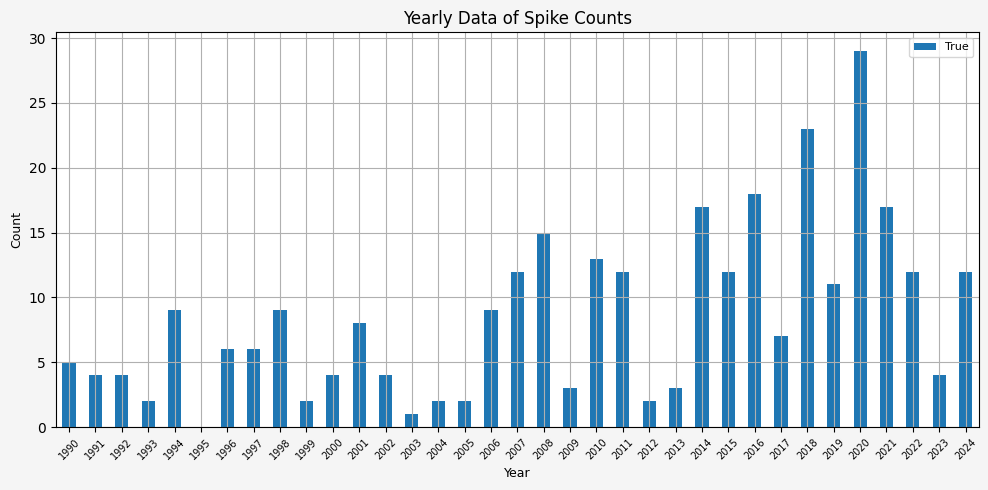

In [22]:
# Plotting the spike counts
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

spike_count[True].plot(kind='bar', stacked=False)

# # Set X axis
# x_tick_spacing = 5  # Specify the interval for y-axis ticks
# plt.gca().xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
plt.xlabel('Year', fontsize = 9)
plt.xticks(rotation = 45, fontsize = 7)

# # Set Y axis
# y_tick_spacing = 25  # Specify the interval for y-axis ticks
# plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
plt.ylabel('Count', fontsize = 9)
# plt.yticks(fontsize = 7)

# # Set title, etc.
plt.title('Yearly Data of Spike Counts')

# Set the grid & legend
plt.tight_layout()
plt.grid(True)
plt.legend(fontsize=8)

# Save the figure
plt.savefig('08_Spike_Counts.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [23]:
def vix_plot(start_year, end_year):
    start_date = start_year + '-01-01'
    end_date = end_year + '-12-31'

    vix_temp = vix[(vix.index >= start_date) & (vix.index <= end_date)]

    # Plotting the VIX
    plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

    plt.plot(vix_temp.index, vix_temp['High'], label='High', linestyle='-', color='b', linewidth=1)
    plt.plot(vix_temp.index, vix_temp['Low'], label='Low', linestyle='-', color='y', linewidth=1)
    plt.plot(vix_temp.index, vix_temp['SMA_10'], label='10 Day High SMA', linestyle='-', color='r', linewidth=1)
    plt.plot(vix_temp.index, vix_temp['SMA_20'], label='20 Day High SMA', linestyle='-', color='orange', linewidth=1)
    plt.plot(vix_temp.index, vix_temp['SMA_50'], label='50 Day High SMA', linestyle='-', color='g', linewidth=1)
    plt.scatter(vix_temp[vix_temp['Spike'] == True].index, vix_temp[vix_temp['Spike'] == True]['High'], label='Spike (High > 1.25 * 10 Day High SMA)', linestyle='-', color='g', s=10)

    # Set X axis
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xlabel('Date', fontsize = 9)
    plt.xticks(rotation = 45, fontsize = 7)

    # Set Y axis
    y_tick_spacing = 5  # Specify the interval for y-axis ticks
    plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
    plt.ylabel('VIX', fontsize = 9)
    plt.yticks(fontsize = 7)

    # Set title, etc.
    plt.title(f'CBOE Volatility Index (VIX), {start_year} - {end_year}', fontsize=12)

    # Display the plot
    plt.tight_layout()
    plt.grid(True)
    plt.legend(fontsize = 8)
    plt.show()

#### 1990

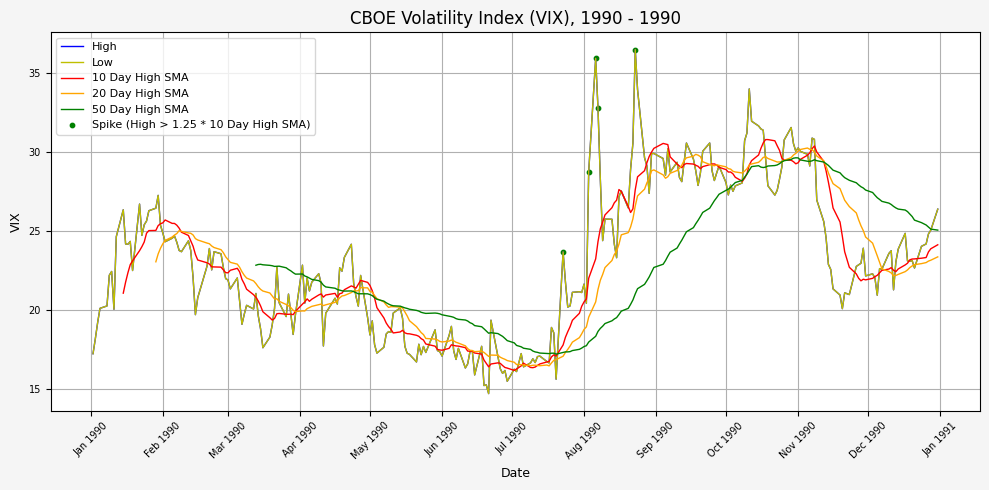

In [24]:
vix_plot('1990', '1990')

#### 1999

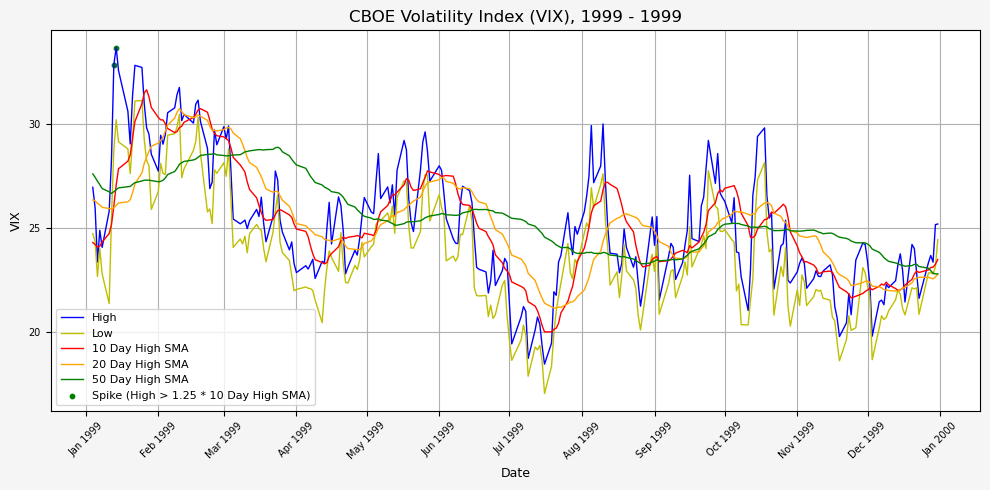

In [28]:
vix_plot('1999', '1999')

#### 2011

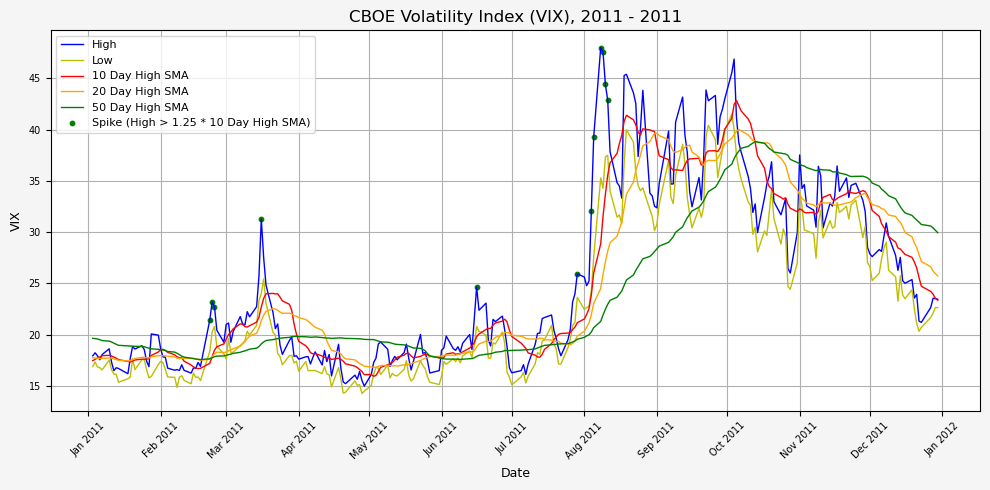

In [26]:
vix_plot('2011', '2011')

#### 2018

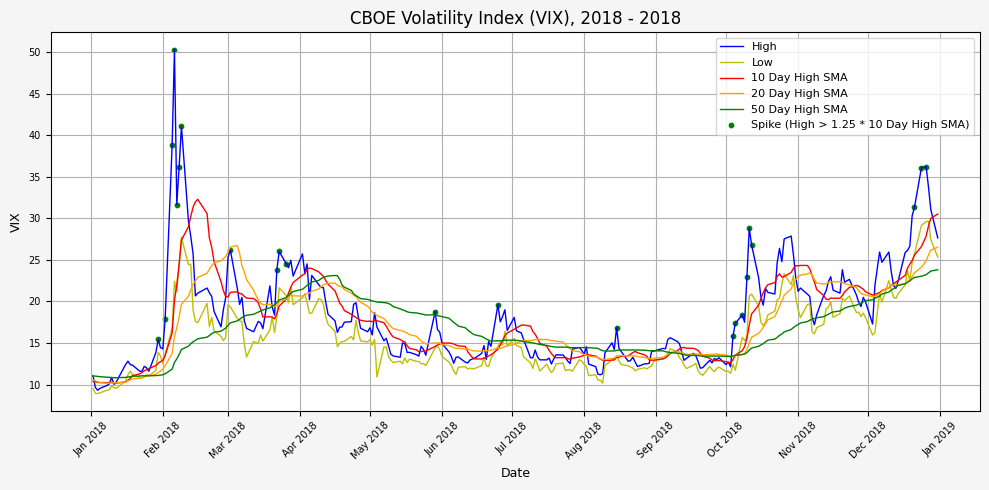

In [25]:
vix_plot('2018', '2018')

#### 2019

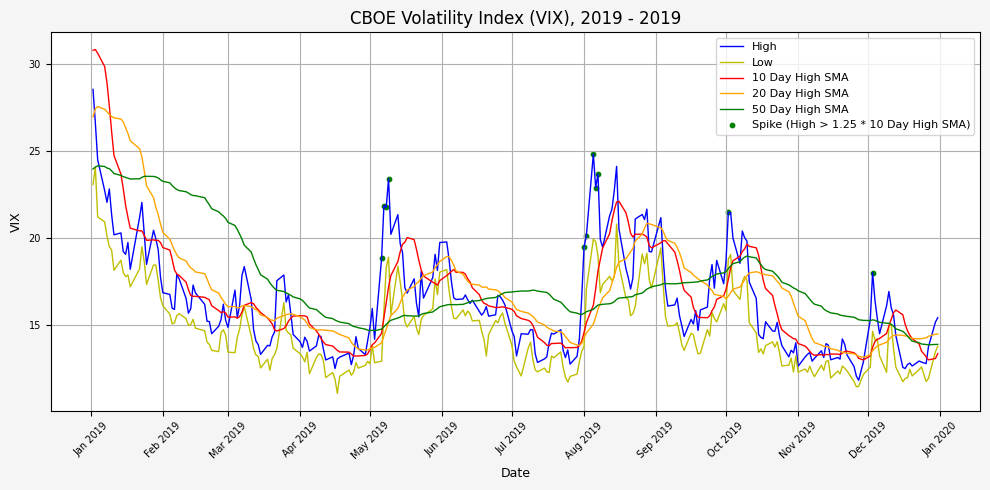

In [26]:
vix_plot('2019', '2019')

#### 2020

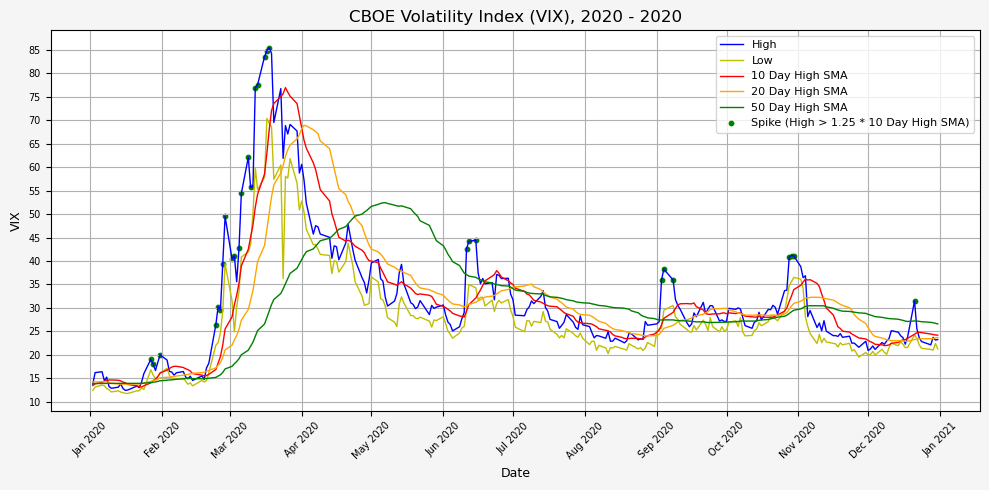

In [131]:
vix_plot('2020', '2020')

#### 2021

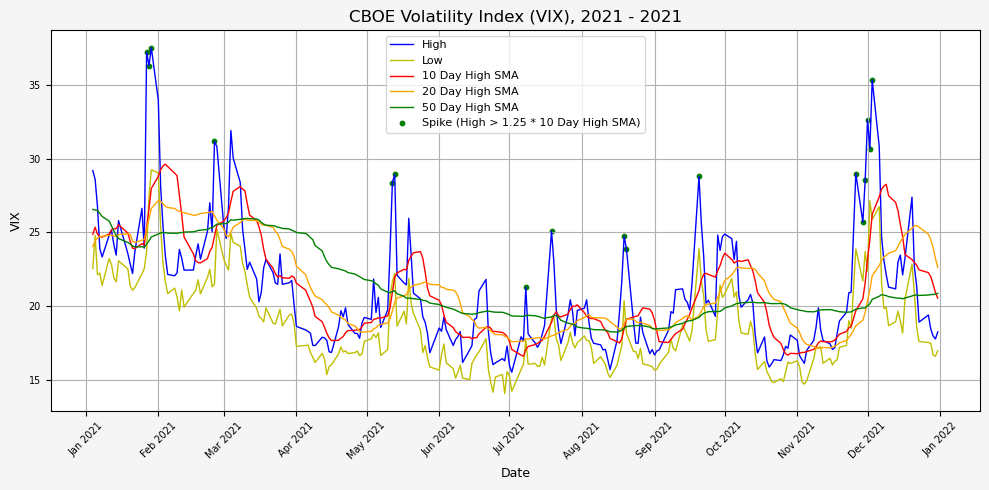

In [132]:
vix_plot('2021', '2021')

#### 2022

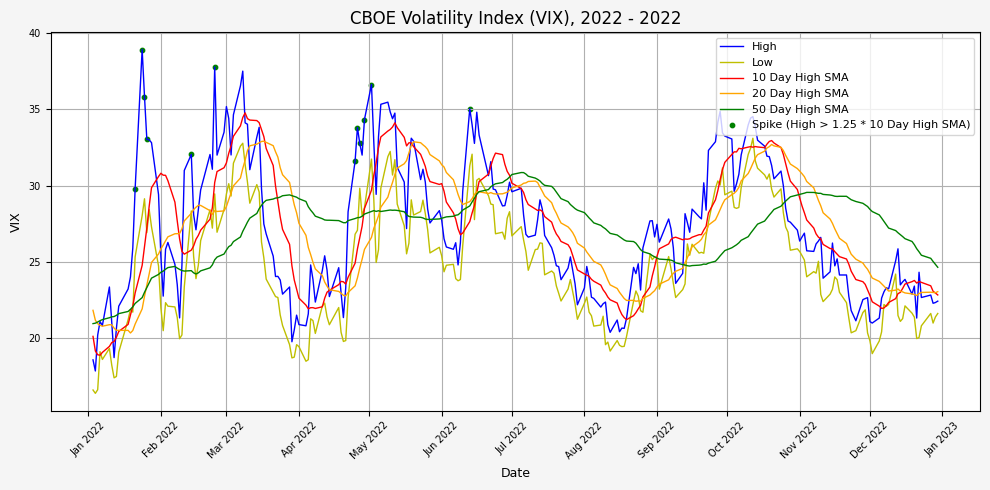

In [28]:
vix_plot('2022', '2022')

#### 2023

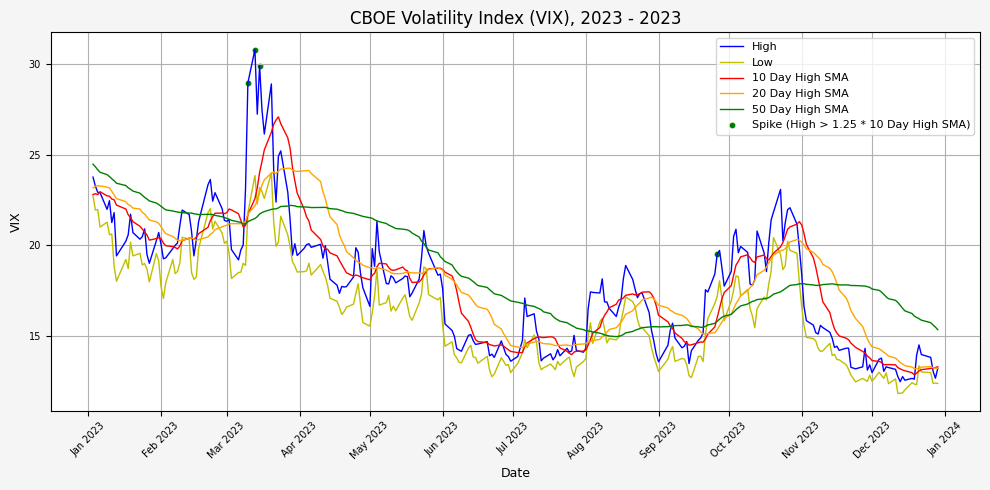

In [29]:
vix_plot('2023', '2023')

#### 2024

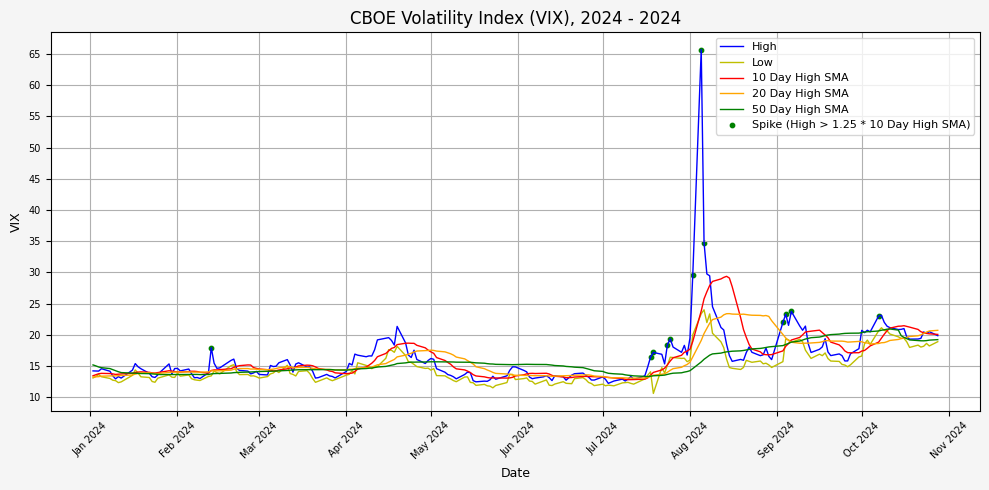

In [30]:
vix_plot('2024', '2024')

#### 2020 - 2024

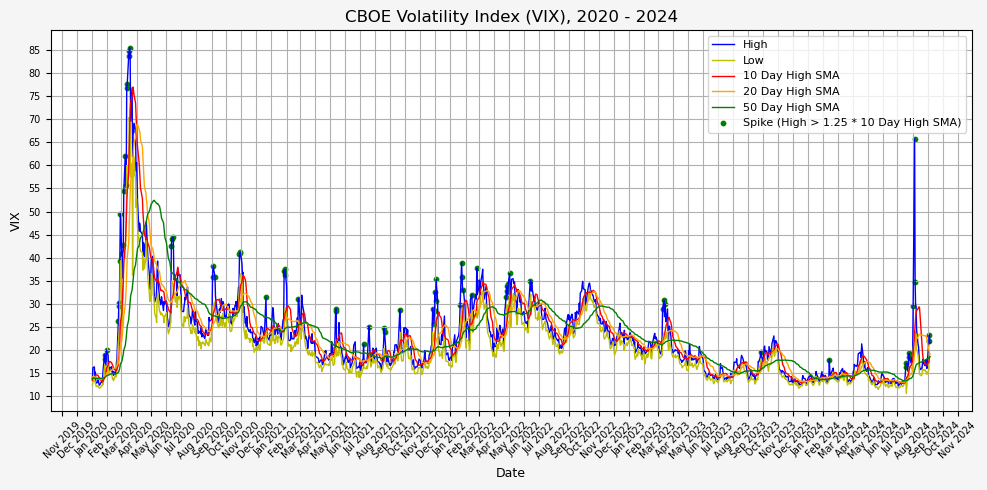

In [136]:
vix_plot('2020', '2024')

In [4]:
def load_data_interpolate(file):
    # Import excel
    df = pd.read_excel('Fund Data/' + file, sheet_name='data', engine='openpyxl')
    df = df[['Date', 'adj_close']]
    df.rename(columns = {'adj_close':'adj_close_orig'}, inplace = True)

    # Filter data & resample
    df = df[(df['Date'] >= '2010-01-01') & (df['Date'] <= '2023-06-30')]
    df.sort_values(by = ['Date'], ascending = True, inplace = True)
    df.set_index('Date', inplace=True)
    df = df.resample('M').last()
    df.interpolate(method='linear', inplace=True)
    df['adj_close'] = df['adj_close_orig'].shift(2)
    return df

In [5]:
# Function to format y-axis as percentage
def percentage(x, pos):
    return '{:.0%}'.format(x)

In [6]:
# Function to calculate returns for a given period
def calculate_returns(start_date, end_date, data):
    data_period = data[(data.index >= start_date) & (data.index <= end_date)]
    data_period['monthly_return'] = data_period['adj_close'].pct_change()
    data_period['cum_monthly_return'] = (1 + data_period['monthly_return']).cumprod()
    return data_period['cum_monthly_return'][-1] - 1  # Return cumulative return at the end of the period

In [7]:
# Function to calculate volatility for a given period
def calculate_vol(start_date, end_date, data):
    data_period = data[(data.index >= start_date) & (data.index <= end_date)]
    data_period['monthly_return'] = data_period['adj_close'].pct_change()
    return data_period['monthly_return'].std() * np.sqrt(12) # annualized for 12 months

In [8]:
# Function to calculate volatility for a given period
def calculate_dd(start_date, end_date, data):
    data_period = data[(data.index >= start_date) & (data.index <= end_date)]
    data_period['monthly_return'] = data_period['adj_close'].pct_change()
    wealth_index = 1000*(1 + data_period).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return drawdowns.min() # annualized for 12 months

In [9]:
# def display_correlation(df, annot=True, list_maxmin=True, cmap='coolwarm', figsize=(10, 8)):
def display_correlation(df, annot=True, list_maxmin=True, figsize=(10, 8)):
    corrmat = df.corr()
    # Ignore self-correlation
    corrmat.values[[i for i in range(len(corrmat))], [i for i in range(len(corrmat))]] = None
    sns.set(font_scale=0.75)
    plt.figure(figsize=figsize)
    # sns.heatmap(corrmat, annot=annot, cmap=cmap, fmt=".2f")  # Setting fmt to display values with 2 decimal places
    sns.heatmap(corrmat, annot=annot, fmt=".2f")  # Setting fmt to display values with 2 decimal places

    if list_maxmin:
        corr_rank = corrmat.unstack().sort_values().dropna()
        pair_max = corr_rank.index[-1]
        pair_min = corr_rank.index[0]

        print(f'MIN Correlation pair is {pair_min}')
        print(f'MAX Correlation pair is {pair_max}')

### Calculate And Combine Annual Returns For Composite Benchmark Proxies

In [11]:
# Generate start and end dates
start_dates = pd.date_range(start='2013-06-30', end='2022-06-30', freq='6M')
start_dates = start_dates[start_dates.month != 12]
end_dates = pd.date_range(start='2014-06-30', end='2023-06-30', freq='6M')
end_dates = end_dates[end_dates.month != 12]

index_dfs = [(iwv, 'IWV'), (efa, 'EFA'), (eem, 'EEM'), (acwx, 'ACWX'), (agg, 'AGG'), (spti, 'SPTI'), (vglt, 'VGLT'), (tip, 'TIP'), 
             (LF98TRUU, 'LF98TRUU'), (SPBDLLB, 'SPBDLLB'), (NPPI0DIV, 'NPPI0DIV'), (LPX50TR, 'LPX50TR'),
             (psp, 'PSP'), (emb, 'EMB'), (hdg, 'HDG'), (cpi, 'CPI')]

fy_index = ['FY 2014', 'FY 2015', 'FY 2016', 'FY 2017', 'FY 2018', 'FY 2019', 'FY 2020', 'FY 2021', 'FY 2022', 'FY 2023']

In [12]:
# Create a DataFrame to store results
cbm_proxy_fund_returns = pd.DataFrame(columns=['Start_Date', 'End_Date', 'IWV'])

for df, name in index_dfs:
    if df.equals(iwv):
        for start, end in zip(start_dates, end_dates):
            start_date_str = start.strftime('%Y-%m-%d')
            end_date_str = end.strftime('%Y-%m-%d')
            returns = calculate_returns(start_date_str, end_date_str, df)
            new_row_data = pd.DataFrame({'Start_Date': [start_date_str], 'End_Date': [end_date_str], 'IWV': [returns]})
            cbm_proxy_fund_returns = pd.concat([cbm_proxy_fund_returns, new_row_data], ignore_index=True)

    else:
        for i, (start, end) in enumerate(zip(start_dates, end_dates)):
            start_date_str = start.strftime('%Y-%m-%d')
            end_date_str = end.strftime('%Y-%m-%d')
            returns = calculate_returns(start_date_str, end_date_str, df)
            cbm_proxy_fund_returns.loc[i, name] = returns

# Set fy_index as the index of the DataFrame
cbm_proxy_fund_returns.index = fy_index
cbm_proxy_fund_returns = cbm_proxy_fund_returns.T
cbm_proxy_fund_returns = cbm_proxy_fund_returns[cbm_proxy_fund_returns.columns[::-1]]
cbm_proxy_fund_returns.index.name = 'Ticker'
cbm_proxy_fund_returns.drop(['Start_Date', 'End_Date'], inplace = True)
display(cbm_proxy_fund_returns)

,FY 2023,FY 2022,FY 2021,FY 2020,FY 2019,FY 2018,FY 2017,FY 2016,FY 2015,FY 2014
Ticker,,,,,,,,,,
IWV,0.174,-0.140,0.440,0.063,0.087,0.146,0.183,0.021,0.071,0.243
EFA,0.182,-0.174,0.326,-0.050,0.013,0.059,0.199,-0.095,-0.047,0.233
EEM,-0.006,-0.256,0.399,-0.043,0.013,0.070,0.224,-0.112,-0.064,0.142
ACWX,0.121,-0.191,0.357,-0.049,0.015,0.064,0.199,-0.095,-0.056,0.217
AGG,-0.026,-0.103,-0.005,0.089,0.077,-0.005,-0.004,0.060,0.017,0.044
SPTI,-0.031,-0.083,-0.021,-0.454,0.077,-0.009,-0.015,0.036,0.009,0.013
VGLT,-0.068,-0.184,-0.106,0.253,0.123,-0.004,-0.071,0.196,0.063,0.067
TIP,-0.032,-0.053,0.061,0.083,0.046,0.020,-0.008,0.045,-0.021,0.044
LF98TRUU,0.091,-0.128,0.154,0.000,0.075,0.026,0.127,0.016,-0.004,0.117


### Calculate And Combine Annual Volatility For Composite Benchmark Proxies

In [13]:
# Create a DataFrame to store results
cbm_proxy_fund_vol = pd.DataFrame(columns=['Start_Date', 'End_Date', 'IWV'])

for df, name in index_dfs:
    if df.equals(iwv):
        for start, end in zip(start_dates, end_dates):
            start_date_str = start.strftime('%Y-%m-%d')
            end_date_str = end.strftime('%Y-%m-%d')
            returns = calculate_vol(start_date_str, end_date_str, df)
            new_row_data = pd.DataFrame({'Start_Date': [start_date_str], 'End_Date': [end_date_str], 'IWV': [returns]})
            cbm_proxy_fund_vol = pd.concat([cbm_proxy_fund_vol, new_row_data], ignore_index=True)

    else:
        for i, (start, end) in enumerate(zip(start_dates, end_dates)):
            start_date_str = start.strftime('%Y-%m-%d')
            end_date_str = end.strftime('%Y-%m-%d')
            returns = calculate_vol(start_date_str, end_date_str, df)
            cbm_proxy_fund_vol.loc[i, name] = returns

# Set fy_index as the index of the DataFrame
cbm_proxy_fund_vol.index = fy_index
cbm_proxy_fund_vol = cbm_proxy_fund_vol.T
cbm_proxy_fund_vol = cbm_proxy_fund_vol[cbm_proxy_fund_vol.columns[::-1]]
cbm_proxy_fund_vol.index.name = 'Ticker'
cbm_proxy_fund_vol.drop(['Start_Date', 'End_Date'], inplace = True)
display(cbm_proxy_fund_vol)

,FY 2023,FY 2022,FY 2021,FY 2020,FY 2019,FY 2018,FY 2017,FY 2016,FY 2015,FY 2014
Ticker,,,,,,,,,,
IWV,0.210,0.175,0.148,0.231,0.194,0.082,0.066,0.149,0.094,0.095
EFA,0.228,0.143,0.159,0.204,0.158,0.089,0.071,0.154,0.106,0.124
EEM,0.250,0.107,0.118,0.236,0.195,0.147,0.101,0.211,0.141,0.139
ACWX,0.223,0.126,0.136,0.210,0.161,0.096,0.068,0.159,0.108,0.119
AGG,0.092,0.051,0.032,0.037,0.034,0.025,0.032,0.025,0.032,0.025
SPTI,0.077,0.044,0.021,0.514,0.034,0.018,0.022,0.020,0.025,0.019
VGLT,0.171,0.121,0.122,0.156,0.116,0.077,0.099,0.085,0.138,0.082
TIP,0.111,0.059,0.038,0.047,0.037,0.025,0.029,0.038,0.051,0.047
LF98TRUU,0.095,0.080,0.056,0.140,0.064,0.020,0.033,0.086,0.050,0.029


### Calculate And Combine Annual Max Drawdown For Composite Benchmark Proxies

In [14]:
# Create a DataFrame to store results
cbm_proxy_fund_dd = pd.DataFrame(columns=['Start_Date', 'End_Date', 'IWV'])

for df, name in index_dfs:
    if df.equals(iwv):
        for start, end in zip(start_dates, end_dates):
            start_date_str = start.strftime('%Y-%m-%d')
            end_date_str = end.strftime('%Y-%m-%d')
            returns = calculate_dd(start_date_str, end_date_str, df)
            new_row_data = pd.DataFrame({'Start_Date': [start_date_str], 'End_Date': [end_date_str], 'IWV': [returns[1]]})
            cbm_proxy_fund_dd = pd.concat([cbm_proxy_fund_dd, new_row_data], ignore_index=True)

    else:
        for i, (start, end) in enumerate(zip(start_dates, end_dates)):
            start_date_str = start.strftime('%Y-%m-%d')
            end_date_str = end.strftime('%Y-%m-%d')
            returns = calculate_dd(start_date_str, end_date_str, df)
            cbm_proxy_fund_dd.loc[i, name] = returns[1]

# Set fy_index as the index of the DataFrame
cbm_proxy_fund_dd.index = fy_index
cbm_proxy_fund_dd = cbm_proxy_fund_dd.T
cbm_proxy_fund_dd = cbm_proxy_fund_dd[cbm_proxy_fund_dd.columns[::-1]]
cbm_proxy_fund_dd.index.name = 'Ticker'
cbm_proxy_fund_dd.drop(['Start_Date', 'End_Date'], inplace = True)
display(cbm_proxy_fund_dd)

,FY 2023,FY 2022,FY 2021,FY 2020,FY 2019,FY 2018,FY 2017,FY 2016,FY 2015,FY 2014
Ticker,,,,,,,,,,
IWV,-0.130,-0.212,-0.055,-0.209,-0.142,-0.056,-0.022,-0.089,-0.028,-0.032
EFA,-0.148,-0.192,-0.055,-0.230,-0.137,-0.075,-0.040,-0.165,-0.079,-0.052
EEM,-0.144,-0.217,-0.010,-0.239,-0.127,-0.145,-0.054,-0.171,-0.122,-0.092
ACWX,-0.140,-0.189,-0.038,-0.234,-0.129,-0.089,-0.038,-0.166,-0.093,-0.061
AGG,-0.086,-0.112,-0.036,-0.006,-0.013,-0.025,-0.035,-0.008,-0.023,-0.008
SPTI,-0.070,-0.094,-0.036,-0.506,-0.008,-0.025,-0.027,-0.007,-0.014,-0.008
VGLT,-0.166,-0.224,-0.193,-0.068,-0.055,-0.061,-0.140,-0.015,-0.123,-0.044
TIP,-0.104,-0.090,-0.019,-0.018,-0.025,-0.019,-0.026,-0.023,-0.031,-0.025
LF98TRUU,-0.062,-0.142,-0.010,-0.127,-0.045,-0.014,-0.005,-0.078,-0.031,-0.006


### Load Composite Benchmark Data

In [15]:
file = 'ISBI Benchmark Indices.xlsx'
df = pd.read_excel('ISBI Data/' + file, sheet_name = 'Benchmark Indices', engine='openpyxl')
df.drop([20, 21], inplace = True)
df.set_index('Ticker', inplace = True)
cbm_weights = df.copy()

In [16]:
cbm_weights

,Asset Class,Fund Index,Proxy Index,FY 2023,FY 2022,FY 2021,FY 2020,FY 2019,FY 2018,FY 2017,FY 2016,FY 2015,FY 2014
Ticker,,,,,,,,,,,,,
IWV,Domestic Equity,Russell 3000,iShares Russell 3000 ETF (IWV),0.230,0.230,0.230,0.230,0.230,0.230,0.230,0.230,0.300,0.300
EFA,International Equity,MSCI EAFE,iShares MSCI EAFE ETF (EFA),0.130,0.130,0.130,0.130,0.130,0.130,0.130,0.130,0.000,0.000
EEM,International Equity,MSCI EM,iShares MSCI Emerging Markets ETF (EEM),0.080,0.080,0.080,0.080,0.080,0.080,0.070,0.070,0.000,0.000
ACWX,International Equity,MSCI ACWI Ex US IMI,iShares MSCI ACWI ex U.S. ETF (ACWX),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.200
AGG,Fixed Income,Barclays Capital US Universal,US Aggregate Bond (AGG),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.250,0.250
AGG,Fixed Income,Barclays Aggregate,US Aggregate Bond (AGG),0.100,0.100,0.100,0.100,0.100,0.100,0.110,0.110,0.000,0.000
SPTI,Fixed Income,Barclays Intermediate Treasuries,SPDR Series Trust - SPDR Portfolio Intermediat...,0.050,0.050,0.040,0.040,0.040,0.040,0.000,0.000,0.000,0.000
VGLT,Fixed Income,Barclays Long Term Treasury Index,Vanguard Long-Term Treasury ETF (VGLT),0.050,0.050,0.040,0.040,0.040,0.040,0.030,0.030,0.000,0.000
TIP,Fixed Income,Custom TIPS Index,iShares TIPS Bond ETF (TIP),0.030,0.030,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


### Combine Composite Benchmark Proxy Fund Returns With Weights

In [17]:
cbm_proxy_returns = pd.DataFrame(columns = ['ISBI CB Proxy Returns', 'ISBI CB Proxy Volatility', 'ISBI CB Proxy Drawdown'])

for year in fy_index:
    combined = pd.merge(cbm_weights[year], cbm_proxy_fund_returns[year], left_on = 'Ticker', right_on = 'Ticker')
    combined.rename(columns = {year + '_x' : year + ' weights', year + '_y': year + ' returns'}, inplace = True)
    combined = pd.merge(combined, cbm_proxy_fund_vol[year], left_on = 'Ticker', right_on = 'Ticker')
    combined.rename(columns = {year:year + ' volatility'}, inplace = True)
    combined = pd.merge(combined, cbm_proxy_fund_dd[year], left_on = 'Ticker', right_on = 'Ticker')
    combined.rename(columns = {year:year + ' drawdown'}, inplace = True)
    combined['weighted_ret'] = combined[year + ' weights'] * combined[year + ' returns']
    weighted_ret = combined['weighted_ret'].sum()
    combined['weighted_vol'] = combined[year + ' weights'] * combined[year + ' volatility']
    weighted_vol = combined['weighted_vol'].sum()
    combined['weighted_dd'] = combined[year + ' weights'] * combined[year + ' drawdown']
    weighted_dd = combined['weighted_dd'].sum()
    cbm_proxy_returns.loc[year] = [weighted_ret, weighted_vol, weighted_dd]

cbm_proxy_returns

,ISBI CB Proxy Returns,ISBI CB Proxy Volatility,ISBI CB Proxy Drawdown
FY 2014,0.159,0.070,-0.028
FY 2015,0.027,0.069,-0.038
FY 2016,0.008,0.104,-0.063
FY 2017,0.127,0.055,-0.026
FY 2018,0.055,0.059,-0.044
FY 2019,0.061,0.115,-0.073
FY 2020,0.001,0.174,-0.140
FY 2021,0.235,0.096,-0.037
FY 2022,-0.072,0.108,-0.130
FY 2023,0.050,0.164,-0.088


## ISBI Composite Benchmark - By Index

This is used for the appendix.

In [18]:
cbm_weights_index = cbm_weights.reset_index()
cbm_weights_index.set_index('Fund Index', inplace = True)
cbm_weights_index.drop(columns = {'Asset Class', 'Proxy Index', 'Ticker'}, inplace = True)
cbm_weights_index

,FY 2023,FY 2022,FY 2021,FY 2020,FY 2019,FY 2018,FY 2017,FY 2016,FY 2015,FY 2014
Fund Index,,,,,,,,,,
Russell 3000,0.230,0.230,0.230,0.230,0.230,0.230,0.230,0.230,0.300,0.300
MSCI EAFE,0.130,0.130,0.130,0.130,0.130,0.130,0.130,0.130,0.000,0.000
MSCI EM,0.080,0.080,0.080,0.080,0.080,0.080,0.070,0.070,0.000,0.000
MSCI ACWI Ex US IMI,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.200
Barclays Capital US Universal,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.250,0.250
Barclays Aggregate,0.100,0.100,0.100,0.100,0.100,0.100,0.110,0.110,0.000,0.000
Barclays Intermediate Treasuries,0.050,0.050,0.040,0.040,0.040,0.040,0.000,0.000,0.000,0.000
Barclays Long Term Treasury Index,0.050,0.050,0.040,0.040,0.040,0.040,0.030,0.030,0.000,0.000
Custom TIPS Index,0.030,0.030,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [19]:
df = cbm_weights_index.T

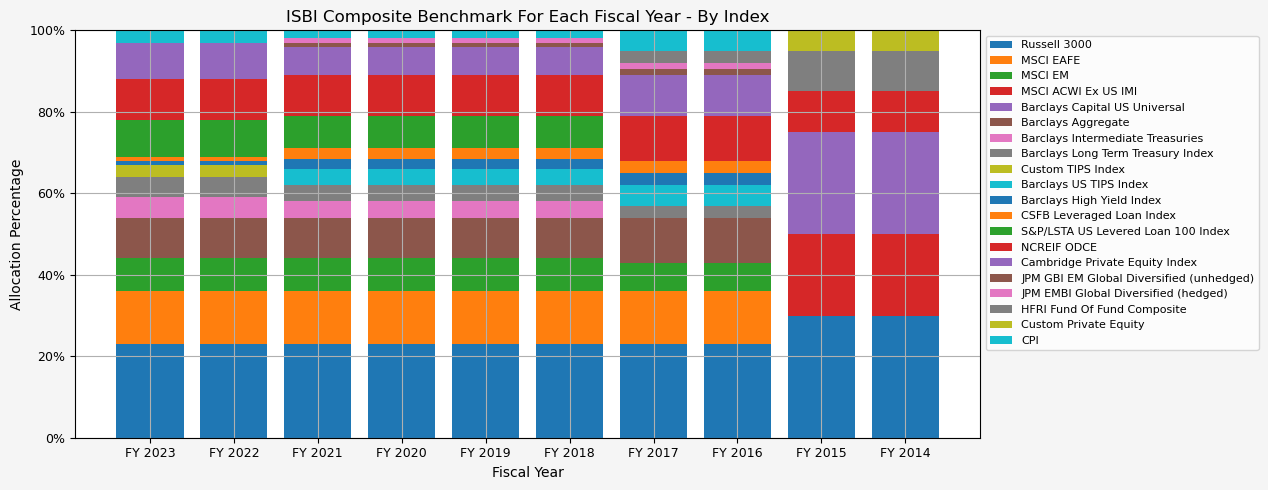

In [20]:
# Create the initial plot
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

for i, asset_class in enumerate(df.columns):
    plt.bar(df.index, df[asset_class], label=asset_class, bottom=df.iloc[:, :i].sum(axis=1))
    
# Set X axis
plt.xlabel('Fiscal Year')
plt.xticks(rotation = 0, fontsize = 9)

# Set Y axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage)) # Formatting y-axis as percentage
plt.ylabel('Allocation Percentage')
plt.yticks(fontsize = 9)
plt.ylim(0, 1)

# Set title, etc.
plt.title('ISBI Composite Benchmark For Each Fiscal Year - By Index', fontsize = 12)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1, 1), fontsize = 8)
plt.grid(True)
plt.show()

## ISBI Composite Benchmark - By Asset Class

This is used for the appendix.

In [21]:
cbm_weights_assetclass = cbm_weights.reset_index()
cbm_weights_assetclass.set_index('Asset Class', inplace = True)
cbm_weights_assetclass.drop(columns = {'Fund Index', 'Proxy Index', 'Ticker'}, inplace = True)
cbm_weights_assetclass = cbm_weights_assetclass.groupby(level=0).sum()
cbm_weights_assetclass

,FY 2023,FY 2022,FY 2021,FY 2020,FY 2019,FY 2018,FY 2017,FY 2016,FY 2015,FY 2014
Asset Class,,,,,,,,,,
Domestic Equity,0.230,0.230,0.230,0.230,0.230,0.230,0.230,0.230,0.300,0.300
Fixed Income,0.240,0.240,0.265,0.265,0.265,0.265,0.250,0.250,0.250,0.250
Hedge Fund,0.000,0.000,0.000,0.000,0.000,0.000,0.030,0.030,0.100,0.100
International Equity,0.210,0.210,0.210,0.210,0.210,0.210,0.200,0.200,0.200,0.200
Other,0.030,0.030,0.020,0.020,0.020,0.020,0.050,0.050,0.000,0.000
Private Credit,0.100,0.100,0.105,0.105,0.105,0.105,0.030,0.030,0.000,0.000
Private Equity,0.090,0.090,0.070,0.070,0.070,0.070,0.100,0.100,0.050,0.050
Real Estate,0.100,0.100,0.100,0.100,0.100,0.100,0.110,0.110,0.100,0.100


In [22]:
df = cbm_weights_assetclass.T

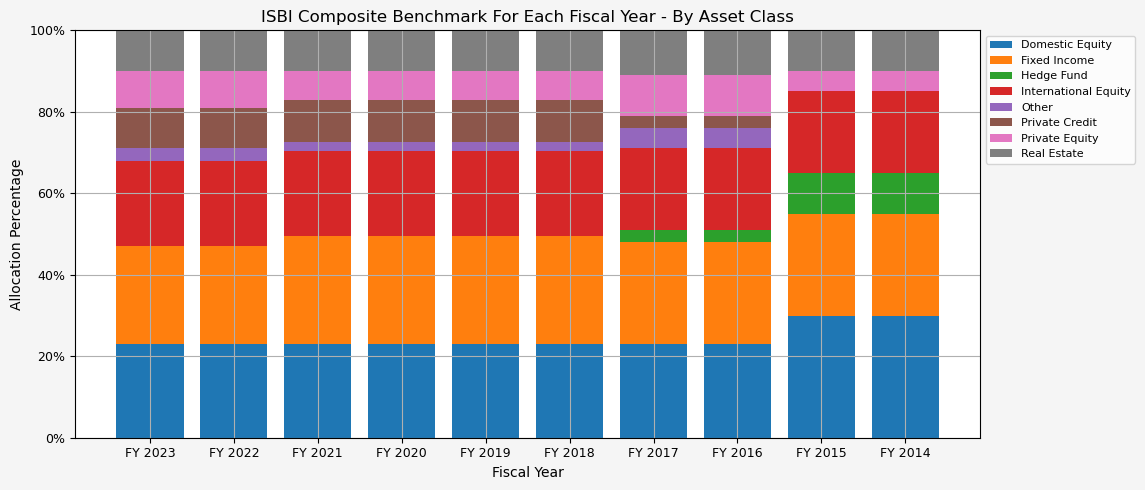

In [23]:
# Create the initial plot
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

for i, asset_class in enumerate(df.columns):
    plt.bar(df.index, df[asset_class], label=asset_class, bottom=df.iloc[:, :i].sum(axis=1))
    
# Set X axis
plt.xlabel('Fiscal Year')
plt.xticks(rotation = 0, fontsize = 9)

# Set Y axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage)) # Formatting y-axis as percentage
plt.ylabel('Allocation Percentage')
plt.yticks(fontsize = 9)
plt.ylim(0, 1)

# Set title, etc.
plt.title('ISBI Composite Benchmark For Each Fiscal Year - By Asset Class', fontsize = 12)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1, 1), fontsize = 8)
plt.grid(True)
plt.show()

## ISBI Policy Targets

This is used for the appendix.

In [24]:
file = 'ISBI Policy Targets.xlsx'
df = pd.read_excel('ISBI Data/' + file, sheet_name = 'Policy Targets', engine='openpyxl')
df.drop([11, 12], inplace = True)
df.set_index('Asset Class / Fiscal Year', inplace = True)

In [25]:
df

,FY 2023,FY 2022,FY 2021,FY 2020,FY 2019,FY 2018,FY 2017,FY 2016,FY 2015,FY 2014
Asset Class / Fiscal Year,,,,,,,,,,
Domestic Equity,0.220,0.230,0.230,0.230,0.230,0.230,0.230,0.230,0.300,0.300
International Equity,0.210,0.210,0.210,0.210,0.210,0.210,0.200,0.200,0.200,0.200
Fixed Income,0.240,0.250,0.290,0.290,0.290,0.260,0.240,0.250,0.160,0.160
Real Estate,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.110,0.100,0.100
Bank Loans,0.000,0.000,0.000,0.000,0.000,0.030,0.020,0.030,0.040,0.040
Private Equity,0.100,0.090,0.070,0.070,0.070,0.070,0.090,0.100,0.050,0.050
Private Credit,0.100,0.090,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Real Assets,0.000,0.000,0.000,0.000,0.000,0.000,0.050,0.050,0.050,0.050
Opportunistic Debt,0.000,0.000,0.080,0.080,0.080,0.080,0.040,0.000,0.000,0.000


In [26]:
df = df.T

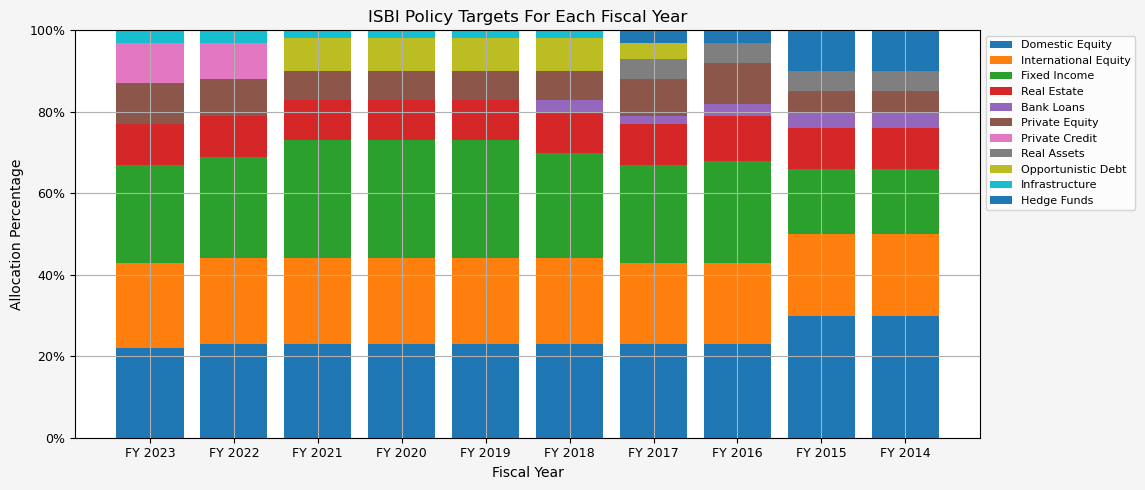

In [27]:
# Create the initial plot
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

for i, asset_class in enumerate(df.columns):
    plt.bar(df.index, df[asset_class], label=asset_class, bottom=df.iloc[:, :i].sum(axis=1))
    
# Set X axis
plt.xlabel('Fiscal Year')
plt.xticks(rotation = 0, fontsize = 9)

# Set Y axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage)) # Formatting y-axis as percentage
plt.ylabel('Allocation Percentage')
plt.yticks(fontsize = 9)
plt.ylim(0, 1)

# Set title, etc.
plt.title('ISBI Policy Targets For Each Fiscal Year', fontsize = 12)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1, 1), fontsize = 8)
plt.grid(True)
plt.show()

## New Fund Returns

### Load Data For New Funds

In [28]:
gsg = load_data('GSG_NDL.xlsx')
gld = load_data('GLD_NDL.xlsx')
btc = load_data('BTC-USD.xlsx')

### Calculate And Combine Annnual Returns For New Funds

In [29]:
# Generate start and end dates
start_dates = pd.date_range(start='2015-06-30', end='2022-06-30', freq='6M')
start_dates = start_dates[start_dates.month != 12]
end_dates = pd.date_range(start='2016-06-30', end='2023-06-30', freq='6M')
end_dates = end_dates[end_dates.month != 12]

index_dfs = [(gsg, 'GSG'), (gld, 'GLD'), (btc, 'BTC')]

fy_index = ['FY 2016', 'FY 2017', 'FY 2018', 'FY 2019', 'FY 2020', 'FY 2021', 'FY 2022', 'FY 2023']

In [30]:
# Create a DataFrame to store results
new_fund_returns = pd.DataFrame(columns=['Start_Date', 'End_Date', 'GSG'])

for df, name in index_dfs:
    if df.equals(gsg):
        for start, end in zip(start_dates, end_dates):
            start_date_str = start.strftime('%Y-%m-%d')
            end_date_str = end.strftime('%Y-%m-%d')
            returns = calculate_returns(start_date_str, end_date_str, df)
            # new_fund_returns = new_fund_returns.append({'Start_Date': start_date_str, 'End_Date': end_date_str, name: returns}, ignore_index=True)
            new_row_data = pd.DataFrame({'Start_Date': [start_date_str], 'End_Date': [end_date_str], 'GSG': [returns]})
            new_fund_returns = pd.concat([new_fund_returns, new_row_data], ignore_index=True)
    else:
        for i, (start, end) in enumerate(zip(start_dates, end_dates)):
            start_date_str = start.strftime('%Y-%m-%d')
            end_date_str = end.strftime('%Y-%m-%d')
            returns = calculate_returns(start_date_str, end_date_str, df)
            new_fund_returns.loc[i, name] = returns

# Set fy_index as the index of the DataFrame
new_fund_returns.index = fy_index
new_fund_returns = new_fund_returns.T
new_fund_returns = new_fund_returns[new_fund_returns.columns[::-1]]
new_fund_returns.index.name = 'Ticker'
new_fund_returns.drop(['Start_Date', 'End_Date'], inplace = True)
display(new_fund_returns)

,FY 2023,FY 2022,FY 2021,FY 2020,FY 2019,FY 2018,FY 2017,FY 2016
Ticker,,,,,,,,
GSG,-0.156,0.436,0.552,-0.337,-0.126,0.277,-0.097,-0.265
GLD,0.058,0.017,-0.010,0.257,0.123,0.005,-0.067,0.125
BTC,0.540,-0.435,2.835,-0.155,0.689,1.581,2.684,1.560


### Calculate And Combine Annnual Volatility For New Funds

In [31]:
# Create a DataFrame to store results
new_fund_vol = pd.DataFrame(columns=['Start_Date', 'End_Date', 'GSG'])

for df, name in index_dfs:
    if df.equals(iwv):
        for start, end in zip(start_dates, end_dates):
            start_date_str = start.strftime('%Y-%m-%d')
            end_date_str = end.strftime('%Y-%m-%d')
            returns = calculate_vol(start_date_str, end_date_str, df)
            # cbm_proxy_returns = cbm_proxy_returns.append({'Start_Date': start_date_str, 'End_Date': end_date_str, name: returns}, ignore_index=True)
            new_row_data = pd.DataFrame({'Start_Date': [start_date_str], 'End_Date': [end_date_str], 'GSG': [returns]})
            new_fund_vol = pd.concat([new_fund_vol, new_row_data], ignore_index=True)

    else:
        for i, (start, end) in enumerate(zip(start_dates, end_dates)):
            start_date_str = start.strftime('%Y-%m-%d')
            end_date_str = end.strftime('%Y-%m-%d')
            returns = calculate_vol(start_date_str, end_date_str, df)
            new_fund_vol.loc[i, name] = returns

# Set fy_index as the index of the DataFrame
new_fund_vol.index = fy_index
new_fund_vol = new_fund_vol.T
new_fund_vol = new_fund_vol[new_fund_vol.columns[::-1]]
new_fund_vol.index.name = 'Ticker'
new_fund_vol.drop(['Start_Date', 'End_Date'], inplace = True)
display(new_fund_vol)

,FY 2023,FY 2022,FY 2021,FY 2020,FY 2019,FY 2018,FY 2017,FY 2016
Ticker,,,,,,,,
GSG,0.134,0.238,0.179,0.396,0.212,0.084,0.140,0.230
GLD,0.160,0.099,0.205,0.126,0.107,0.087,0.124,0.206
BTC,0.561,0.734,0.854,0.626,0.864,1.193,0.761,0.553


### Calculate And Combine Annnual Max Drawdown For New Funds

In [32]:
# Create a DataFrame to store results
new_fund_dd = pd.DataFrame(columns=['Start_Date', 'End_Date', 'GSG'])

for df, name in index_dfs:
    if df.equals(iwv):
        for start, end in zip(start_dates, end_dates):
            start_date_str = start.strftime('%Y-%m-%d')
            end_date_str = end.strftime('%Y-%m-%d')
            returns = calculate_dd(start_date_str, end_date_str, df)
            new_row_data = pd.DataFrame({'Start_Date': [start_date_str], 'End_Date': [end_date_str], 'IWV': [returns[1]]})
            new_fund_dd = pd.concat([new_fund_dd, new_row_data], ignore_index=True)

    else:
        for i, (start, end) in enumerate(zip(start_dates, end_dates)):
            start_date_str = start.strftime('%Y-%m-%d')
            end_date_str = end.strftime('%Y-%m-%d')
            returns = calculate_dd(start_date_str, end_date_str, df)
            new_fund_dd.loc[i, name] = returns[1]

# Set fy_index as the index of the DataFrame
new_fund_dd.index = fy_index
new_fund_dd = new_fund_dd.T
new_fund_dd = new_fund_dd[new_fund_dd.columns[::-1]]
new_fund_dd.index.name = 'Ticker'
new_fund_dd.drop(['Start_Date', 'End_Date'], inplace = True)
display(new_fund_dd)

,FY 2023,FY 2022,FY 2021,FY 2020,FY 2019,FY 2018,FY 2017,FY 2016
Ticker,,,,,,,,
GSG,-0.186,-0.106,-0.077,-0.477,-0.226,-0.037,-0.105,-0.274
GLD,-0.074,-0.067,-0.137,-0.041,-0.028,-0.071,-0.150,-0.072
BTC,-0.291,-0.677,-0.405,-0.362,-0.556,-0.548,-0.092,-0.192


## Modified ISBI Composite Benchmark - By Index

Here we pull in the composite benchmark data and rescale to allow for an allocation to additional asset classes.

In [33]:
# start with the df for the composite benchmark weights
cbm_weights_mod = cbm_weights.copy()
cbm_weights_mod.drop(columns = {'Asset Class', 'Proxy Index', 'Fund Index'}, inplace = True)

In [34]:
# Adding a new row for the new asset class
# new_asset_class1 = 'GSG'
new_asset_class2 = 'BTC'
# new_asset_class3 = 'GLD'

# allocation_percentage = 0.111
# allocation_percentage = 0.075
# allocation_percentage = 0.053
allocation_percentage = 0.099
# allocation_percentage = 0.01

# cbm_weights_mod.loc[new_asset_class1] = allocation_percentage
cbm_weights_mod.loc[new_asset_class2] = allocation_percentage
# cbm_weights_mod.loc[new_asset_class3] = allocation_percentage

# Re-scaling the weightings to ensure they sum up to 1
total_weight = cbm_weights_mod.sum(axis=0)
cbm_weights_mod = cbm_weights_mod.div(total_weight)
cbm_weights_mod.loc['Total'] = cbm_weights_mod.sum()

In [35]:
cbm_weights_mod

,FY 2023,FY 2022,FY 2021,FY 2020,FY 2019,FY 2018,FY 2017,FY 2016,FY 2015,FY 2014
Ticker,,,,,,,,,,
IWV,0.209,0.209,0.209,0.209,0.209,0.209,0.209,0.209,0.273,0.273
EFA,0.118,0.118,0.118,0.118,0.118,0.118,0.118,0.118,0.000,0.000
EEM,0.073,0.073,0.073,0.073,0.073,0.073,0.064,0.064,0.000,0.000
ACWX,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.182,0.182
AGG,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.227,0.227
AGG,0.091,0.091,0.091,0.091,0.091,0.091,0.100,0.100,0.000,0.000
SPTI,0.045,0.045,0.036,0.036,0.036,0.036,0.000,0.000,0.000,0.000
VGLT,0.045,0.045,0.036,0.036,0.036,0.036,0.027,0.027,0.000,0.000
TIP,0.027,0.027,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [36]:
combined_returns = pd.concat([cbm_proxy_fund_returns, new_fund_returns])
combined_vol = pd.concat([cbm_proxy_fund_vol, new_fund_vol])
combined_dd = pd.concat([cbm_proxy_fund_dd, new_fund_dd])

In [37]:
cbm_proxy_mod_returns = pd.DataFrame(columns = ['Modified ISBI CB Proxy Returns', 'Modified ISBI CB Proxy Volatility', 'Modified ISBI CB Proxy Drawdown'])

for year in fy_index:
    combined = pd.merge(cbm_weights_mod[year], combined_returns[year], left_on = 'Ticker', right_on = 'Ticker')
    combined.rename(columns = {year + '_x' : year + ' weights', year + '_y': year + ' returns'}, inplace = True)
    combined = pd.merge(combined, combined_vol[year], left_on = 'Ticker', right_on = 'Ticker')
    combined.rename(columns = {year:year + ' volatility'}, inplace = True)
    combined = pd.merge(combined, combined_dd[year], left_on = 'Ticker', right_on = 'Ticker')
    combined.rename(columns = {year:year + ' drawdown'}, inplace = True)
    combined['weighted_ret'] = combined[year + ' weights'] * combined[year + ' returns']
    weighted_ret = combined['weighted_ret'].sum()
    combined['weighted_vol'] = combined[year + ' weights'] * combined[year + ' volatility']
    weighted_vol = combined['weighted_vol'].sum()
    combined['weighted_dd'] = combined[year + ' weights'] * combined[year + ' drawdown']
    weighted_dd = combined['weighted_dd'].sum()
    cbm_proxy_mod_returns.loc[year] = [weighted_ret, weighted_vol, weighted_dd]

cbm_proxy_mod_returns

,Modified ISBI CB Proxy Returns,Modified ISBI CB Proxy Volatility,Modified ISBI CB Proxy Drawdown
FY 2016,0.148,0.144,-0.075
FY 2017,0.357,0.119,-0.032
FY 2018,0.192,0.161,-0.089
FY 2019,0.117,0.183,-0.117
FY 2020,-0.013,0.215,-0.160
FY 2021,0.469,0.165,-0.070
FY 2022,-0.105,0.164,-0.179
FY 2023,0.094,0.200,-0.106


## Composite Benchmark Returns & Volatility Comparison

Here we compare the ISBI composite benchmark, the proxy composite benchmark, and the modified benchmark returns.

In [38]:
ret_comp = cbm_proxy_returns.copy()
ret_comp['ISBI CB Returns'] = [0.163, 0.040, 0.007, 0.120, 0.074, 0.070, 0.049, 0.219, -0.059, 0.063]
ret_comp['ISBI Fund Returns'] = [0.179, 0.047, -0.008, 0.123, 0.076, 0.071, 0.046, 0.258, -0.063, 0.062]
ret_comp = ret_comp[['ISBI Fund Returns', 'ISBI CB Returns', 
                     'ISBI CB Proxy Returns', 'ISBI CB Proxy Volatility', 'ISBI CB Proxy Drawdown']]
ret_comp = pd.merge(ret_comp, cbm_proxy_mod_returns, left_on = ret_comp.index, right_on = cbm_proxy_mod_returns.index)
ret_comp.set_index('key_0', inplace = True)
ret_comp.index.name = ''

In [39]:
ifr_cagr = (1 + ret_comp['ISBI Fund Returns']).cumprod()
ifr_cagr = (ifr_cagr[-1] / 1) ** (1/8) - 1

icbr_cagr = (1 + ret_comp['ISBI CB Returns']).cumprod()
icbr_cagr = (icbr_cagr[-1] / 1) ** (1/8) - 1

icbpr_cagr = (1 + ret_comp['ISBI CB Proxy Returns']).cumprod()
icbpr_cagr = (icbpr_cagr[-1] / 1) ** (1/8) - 1

icbpr_anvol = ret_comp['ISBI CB Proxy Volatility'].mean()

micbpr_cagr = (1 + ret_comp['Modified ISBI CB Proxy Returns']).cumprod()
micbpr_cagr = (micbpr_cagr[-1] / 1) ** (1/8) - 1

micbpr_anvol = ret_comp['Modified ISBI CB Proxy Volatility'].mean()

ret_comp.loc['CAGR'] = ['','','','','','','','']
ret_comp.loc['Mean Vol'] = ['','','','','','','','']

ret_comp.at['CAGR', 'ISBI Fund Returns'] = ifr_cagr
ret_comp.at['CAGR', 'ISBI CB Returns'] = icbr_cagr
ret_comp.at['CAGR', 'ISBI CB Proxy Returns'] = icbpr_cagr
ret_comp.at['CAGR', 'Modified ISBI CB Proxy Returns'] = micbpr_cagr
ret_comp.at['Mean Vol', 'ISBI CB Proxy Volatility'] = icbpr_anvol
ret_comp.at['Mean Vol', 'Modified ISBI CB Proxy Volatility'] = micbpr_anvol

ret_comp

,ISBI Fund Returns,ISBI CB Returns,ISBI CB Proxy Returns,ISBI CB Proxy Volatility,ISBI CB Proxy Drawdown,Modified ISBI CB Proxy Returns,Modified ISBI CB Proxy Volatility,Modified ISBI CB Proxy Drawdown
,,,,,,,,
FY 2016,-0.008,0.007,0.008,0.104,-0.063,0.148,0.144,-0.075
FY 2017,0.123,0.120,0.127,0.055,-0.026,0.357,0.119,-0.032
FY 2018,0.076,0.074,0.055,0.059,-0.044,0.192,0.161,-0.089
FY 2019,0.071,0.070,0.061,0.115,-0.073,0.117,0.183,-0.117
FY 2020,0.046,0.049,0.001,0.174,-0.140,-0.013,0.215,-0.160
FY 2021,0.258,0.219,0.235,0.096,-0.037,0.469,0.165,-0.070
FY 2022,-0.063,-0.059,-0.072,0.108,-0.130,-0.105,0.164,-0.179
FY 2023,0.062,0.063,0.050,0.164,-0.088,0.094,0.200,-0.106
CAGR,0.067,0.065,0.055,,,0.145,,


## Portfolio Weighting Analysis - BTC

Here we pull in the composite benchmark data and rescale to allow for an allocation to additional asset classes.

In [65]:
btc_weights = [(0.01, 0.01, '1%'), (0.02, 0.02, '2%'), (0.031, 0.03, '3%'), (0.042, 0.04, '4%'), (0.053, 0.05, '5%'), 
               (0.064, 0.06, '6%'), (0.075, 0.07, '7%'), (0.087, 0.08, '8%'), (0.099, 0.09, '9%'), (0.111, 0.10, '10%')]
# btc_weights = [(0.01, 0.01), (0.031, 0.03), (0.053, 0.05), (0.075, 0.07)]

ret_comp_all = pd.DataFrame(columns = ['ISBI CB Proxy CAGR', 'ISBI CB Proxy Mean Annual Volatility', 'ISBI CB Proxy Max Drawdown',
                                       'Modified ISBI CB Proxy CAGR', 'Modified ISBI CB Proxy Mean Annual Volatility',
                                       'Modified ISBI CB Proxy Max Drawdown'])

fy_index = ['FY 2016', 'FY 2017', 'FY 2018', 'FY 2019', 'FY 2020', 'FY 2021', 'FY 2022', 'FY 2023']
cum_ret = pd.DataFrame(index = fy_index)

for weight, size, percent in btc_weights:
    # start with the df for the composite benchmark weights
    cbm_weights_mod = cbm_weights.copy()
    cbm_weights_mod.drop(columns = {'Asset Class', 'Proxy Index', 'Fund Index'}, inplace = True)

    new_asset_class1 = 'BTC'
    allocation_percentage = weight
    cbm_weights_mod.loc[new_asset_class1] = allocation_percentage
    
    # Re-scaling the weightings to ensure they sum up to 1
    total_weight = cbm_weights_mod.sum(axis=0)
    cbm_weights_mod = cbm_weights_mod.div(total_weight)

    cbm_proxy_mod_returns = pd.DataFrame(columns = ['Modified ISBI CB Proxy Returns', 'Modified ISBI CB Proxy Volatility', 'Modified ISBI CB Proxy Drawdown'])

    for year in fy_index:
        combined = pd.merge(cbm_weights_mod[year], combined_returns[year], left_on = 'Ticker', right_on = 'Ticker')
        combined.rename(columns = {year + '_x' : year + ' weights', year + '_y': year + ' returns'}, inplace = True)
        combined = pd.merge(combined, combined_vol[year], left_on = 'Ticker', right_on = 'Ticker')
        combined.rename(columns = {year:year + ' volatility'}, inplace = True)
        combined = pd.merge(combined, combined_dd[year], left_on = 'Ticker', right_on = 'Ticker')
        combined.rename(columns = {year:year + ' drawdown'}, inplace = True)
        combined['weighted_ret'] = combined[year + ' weights'] * combined[year + ' returns']
        weighted_ret = combined['weighted_ret'].sum()
        combined['weighted_vol'] = combined[year + ' weights'] * combined[year + ' volatility']
        weighted_vol = combined['weighted_vol'].sum()
        combined['weighted_dd'] = combined[year + ' weights'] * combined[year + ' drawdown']
        weighted_dd = combined['weighted_dd'].sum()
        cbm_proxy_mod_returns.loc[year] = [weighted_ret, weighted_vol, weighted_dd]

    ret_comp = pd.merge(cbm_proxy_returns, cbm_proxy_mod_returns, left_on = cbm_proxy_returns.index, right_on = cbm_proxy_mod_returns.index)
    ret_comp.set_index('key_0', inplace = True)
    ret_comp.index.name = ''

    icbpr_cagr = (1 + ret_comp['ISBI CB Proxy Returns']).cumprod()
    icbpr_cagr = (icbpr_cagr[-1] / 1) ** (1/8) - 1
    
    icbpr_anvol = ret_comp['ISBI CB Proxy Volatility'].mean()

    icbpr_dd = ret_comp['ISBI CB Proxy Drawdown'].min()
        
    micbpr_cagr = (1 + ret_comp['Modified ISBI CB Proxy Returns']).cumprod()
    micbpr_cagr = (micbpr_cagr[-1] / 1) ** (1/8) - 1
    
    micbpr_anvol = ret_comp['Modified ISBI CB Proxy Volatility'].mean()

    micbpr_dd = ret_comp['Modified ISBI CB Proxy Drawdown'].min()

    ret_comp_all.loc['BTC ' + str(size)] = [icbpr_cagr, icbpr_anvol, icbpr_dd, micbpr_cagr, micbpr_anvol, micbpr_dd]

    cum_ret = pd.concat([cum_ret, ret_comp['Modified ISBI CB Proxy Returns']], axis = 1)
    cum_ret.rename(columns = {'Modified ISBI CB Proxy Returns':'ISBI CB + ' + percent + ' BTC'}, inplace = True)

cum_ret = pd.concat([cum_ret, ret_comp['ISBI CB Proxy Returns']], axis = 1)
    
ret_comp_all.insert(2, 'ISBI CB Proxy Sharpe Ratio', ret_comp_all['ISBI CB Proxy CAGR'] / ret_comp_all['ISBI CB Proxy Mean Annual Volatility'])
ret_comp_all.insert(5, 'Modified ISBI CB Proxy Sharpe Ratio', ret_comp_all['Modified ISBI CB Proxy CAGR'] / ret_comp_all['Modified ISBI CB Proxy Mean Annual Volatility'])

ret_comp_all

,ISBI CB Proxy CAGR,ISBI CB Proxy Mean Annual Volatility,ISBI CB Proxy Sharpe Ratio,ISBI CB Proxy Max Drawdown,Modified ISBI CB Proxy CAGR,Modified ISBI CB Proxy Sharpe Ratio,Modified ISBI CB Proxy Mean Annual Volatility,Modified ISBI CB Proxy Max Drawdown
BTC 0.01,0.055,0.110,0.499,-0.140,0.065,0.559,0.116,-0.142
BTC 0.02,0.055,0.110,0.499,-0.140,0.075,0.611,0.122,-0.144
BTC 0.03,0.055,0.110,0.499,-0.140,0.085,0.661,0.129,-0.146
BTC 0.04,0.055,0.110,0.499,-0.140,0.096,0.704,0.136,-0.152
BTC 0.05,0.055,0.110,0.499,-0.140,0.106,0.742,0.143,-0.158
BTC 0.06,0.055,0.110,0.499,-0.140,0.116,0.775,0.149,-0.163
BTC 0.07,0.055,0.110,0.499,-0.140,0.125,0.804,0.155,-0.168
BTC 0.08,0.055,0.110,0.499,-0.140,0.135,0.832,0.162,-0.174
BTC 0.09,0.055,0.110,0.499,-0.140,0.145,0.857,0.169,-0.179
BTC 0.1,0.055,0.110,0.499,-0.140,0.154,0.879,0.175,-0.185


In [66]:
final_df = pd.DataFrame()
# CAGR
final_df.loc['ISBI CB Proxy', 'CAGR'] = ret_comp_all.loc['BTC 0.03', 'ISBI CB Proxy CAGR']
final_df.loc['ISBI CB + 1% BTC', 'CAGR'] = ret_comp_all.loc['BTC 0.01', 'Modified ISBI CB Proxy CAGR']
final_df.loc['ISBI CB + 2% BTC', 'CAGR'] = ret_comp_all.loc['BTC 0.02', 'Modified ISBI CB Proxy CAGR']
final_df.loc['ISBI CB + 3% BTC', 'CAGR'] = ret_comp_all.loc['BTC 0.03', 'Modified ISBI CB Proxy CAGR']
final_df.loc['ISBI CB + 4% BTC', 'CAGR'] = ret_comp_all.loc['BTC 0.04', 'Modified ISBI CB Proxy CAGR']
final_df.loc['ISBI CB + 5% BTC', 'CAGR'] = ret_comp_all.loc['BTC 0.05', 'Modified ISBI CB Proxy CAGR']
final_df.loc['ISBI CB + 6% BTC', 'CAGR'] = ret_comp_all.loc['BTC 0.06', 'Modified ISBI CB Proxy CAGR']
final_df.loc['ISBI CB + 7% BTC', 'CAGR'] = ret_comp_all.loc['BTC 0.07', 'Modified ISBI CB Proxy CAGR']
final_df.loc['ISBI CB + 8% BTC', 'CAGR'] = ret_comp_all.loc['BTC 0.08', 'Modified ISBI CB Proxy CAGR']
final_df.loc['ISBI CB + 9% BTC', 'CAGR'] = ret_comp_all.loc['BTC 0.09', 'Modified ISBI CB Proxy CAGR']
final_df.loc['ISBI CB + 10% BTC', 'CAGR'] = ret_comp_all.loc['BTC 0.1', 'Modified ISBI CB Proxy CAGR']

# vol
final_df.loc['ISBI CB Proxy', 'Mean Annual Volatility'] = ret_comp_all.loc['BTC 0.03', 'ISBI CB Proxy Mean Annual Volatility']
final_df.loc['ISBI CB + 1% BTC', 'Mean Annual Volatility'] = ret_comp_all.loc['BTC 0.01', 'Modified ISBI CB Proxy Mean Annual Volatility']
final_df.loc['ISBI CB + 2% BTC', 'Mean Annual Volatility'] = ret_comp_all.loc['BTC 0.02', 'Modified ISBI CB Proxy Mean Annual Volatility']
final_df.loc['ISBI CB + 3% BTC', 'Mean Annual Volatility'] = ret_comp_all.loc['BTC 0.03', 'Modified ISBI CB Proxy Mean Annual Volatility']
final_df.loc['ISBI CB + 4% BTC', 'Mean Annual Volatility'] = ret_comp_all.loc['BTC 0.04', 'Modified ISBI CB Proxy Mean Annual Volatility']
final_df.loc['ISBI CB + 5% BTC', 'Mean Annual Volatility'] = ret_comp_all.loc['BTC 0.05', 'Modified ISBI CB Proxy Mean Annual Volatility']
final_df.loc['ISBI CB + 6% BTC', 'Mean Annual Volatility'] = ret_comp_all.loc['BTC 0.06', 'Modified ISBI CB Proxy Mean Annual Volatility']
final_df.loc['ISBI CB + 7% BTC', 'Mean Annual Volatility'] = ret_comp_all.loc['BTC 0.07', 'Modified ISBI CB Proxy Mean Annual Volatility']
final_df.loc['ISBI CB + 8% BTC', 'Mean Annual Volatility'] = ret_comp_all.loc['BTC 0.08', 'Modified ISBI CB Proxy Mean Annual Volatility']
final_df.loc['ISBI CB + 9% BTC', 'Mean Annual Volatility'] = ret_comp_all.loc['BTC 0.09', 'Modified ISBI CB Proxy Mean Annual Volatility']
final_df.loc['ISBI CB + 10% BTC', 'Mean Annual Volatility'] = ret_comp_all.loc['BTC 0.1', 'Modified ISBI CB Proxy Mean Annual Volatility']

# sharpe
final_df.loc['ISBI CB Proxy', 'Sharpe Ratio'] = ret_comp_all.loc['BTC 0.03', 'ISBI CB Proxy Sharpe Ratio']
final_df.loc['ISBI CB + 1% BTC', 'Sharpe Ratio'] = ret_comp_all.loc['BTC 0.01', 'Modified ISBI CB Proxy Sharpe Ratio']
final_df.loc['ISBI CB + 2% BTC', 'Sharpe Ratio'] = ret_comp_all.loc['BTC 0.02', 'Modified ISBI CB Proxy Sharpe Ratio']
final_df.loc['ISBI CB + 3% BTC', 'Sharpe Ratio'] = ret_comp_all.loc['BTC 0.03', 'Modified ISBI CB Proxy Sharpe Ratio']
final_df.loc['ISBI CB + 4% BTC', 'Sharpe Ratio'] = ret_comp_all.loc['BTC 0.04', 'Modified ISBI CB Proxy Sharpe Ratio']
final_df.loc['ISBI CB + 5% BTC', 'Sharpe Ratio'] = ret_comp_all.loc['BTC 0.05', 'Modified ISBI CB Proxy Sharpe Ratio']
final_df.loc['ISBI CB + 6% BTC', 'Sharpe Ratio'] = ret_comp_all.loc['BTC 0.06', 'Modified ISBI CB Proxy Sharpe Ratio']
final_df.loc['ISBI CB + 7% BTC', 'Sharpe Ratio'] = ret_comp_all.loc['BTC 0.07', 'Modified ISBI CB Proxy Sharpe Ratio']
final_df.loc['ISBI CB + 8% BTC', 'Sharpe Ratio'] = ret_comp_all.loc['BTC 0.08', 'Modified ISBI CB Proxy Sharpe Ratio']
final_df.loc['ISBI CB + 9% BTC', 'Sharpe Ratio'] = ret_comp_all.loc['BTC 0.09', 'Modified ISBI CB Proxy Sharpe Ratio']
final_df.loc['ISBI CB + 10% BTC', 'Sharpe Ratio'] = ret_comp_all.loc['BTC 0.1', 'Modified ISBI CB Proxy Sharpe Ratio']

# drawdown
final_df.loc['ISBI CB Proxy', 'Max Drawdown'] = ret_comp_all.loc['BTC 0.03', 'ISBI CB Proxy Max Drawdown']
final_df.loc['ISBI CB + 1% BTC', 'Max Drawdown'] = ret_comp_all.loc['BTC 0.01', 'Modified ISBI CB Proxy Max Drawdown']
final_df.loc['ISBI CB + 2% BTC', 'Max Drawdown'] = ret_comp_all.loc['BTC 0.02', 'Modified ISBI CB Proxy Max Drawdown']
final_df.loc['ISBI CB + 3% BTC', 'Max Drawdown'] = ret_comp_all.loc['BTC 0.03', 'Modified ISBI CB Proxy Max Drawdown']
final_df.loc['ISBI CB + 4% BTC', 'Max Drawdown'] = ret_comp_all.loc['BTC 0.04', 'Modified ISBI CB Proxy Max Drawdown']
final_df.loc['ISBI CB + 5% BTC', 'Max Drawdown'] = ret_comp_all.loc['BTC 0.05', 'Modified ISBI CB Proxy Max Drawdown']
final_df.loc['ISBI CB + 6% BTC', 'Max Drawdown'] = ret_comp_all.loc['BTC 0.06', 'Modified ISBI CB Proxy Max Drawdown']
final_df.loc['ISBI CB + 7% BTC', 'Max Drawdown'] = ret_comp_all.loc['BTC 0.07', 'Modified ISBI CB Proxy Max Drawdown']
final_df.loc['ISBI CB + 8% BTC', 'Max Drawdown'] = ret_comp_all.loc['BTC 0.08', 'Modified ISBI CB Proxy Max Drawdown']
final_df.loc['ISBI CB + 9% BTC', 'Max Drawdown'] = ret_comp_all.loc['BTC 0.09', 'Modified ISBI CB Proxy Max Drawdown']
final_df.loc['ISBI CB + 10% BTC', 'Max Drawdown'] = ret_comp_all.loc['BTC 0.1', 'Modified ISBI CB Proxy Max Drawdown']

In [67]:
final_df

,CAGR,Mean Annual Volatility,Sharpe Ratio,Max Drawdown
ISBI CB Proxy,0.055,0.110,0.499,-0.140
ISBI CB + 1% BTC,0.065,0.116,0.559,-0.142
ISBI CB + 2% BTC,0.075,0.122,0.611,-0.144
ISBI CB + 3% BTC,0.085,0.129,0.661,-0.146
ISBI CB + 4% BTC,0.096,0.136,0.704,-0.152
ISBI CB + 5% BTC,0.106,0.143,0.742,-0.158
ISBI CB + 6% BTC,0.116,0.149,0.775,-0.163
ISBI CB + 7% BTC,0.125,0.155,0.804,-0.168
ISBI CB + 8% BTC,0.135,0.162,0.832,-0.174
ISBI CB + 9% BTC,0.145,0.169,0.857,-0.179


In [68]:
final_df['CAGR Percent Change'] = final_df['CAGR'].pct_change()
final_df['Volatility Percent Change'] = final_df['Mean Annual Volatility'].pct_change()
final_df['Sharpe Percent Change'] = final_df['Sharpe Ratio'].pct_change()

In [69]:
final_df

,CAGR,Mean Annual Volatility,Sharpe Ratio,Max Drawdown,CAGR Percent Change,Volatility Percent Change,Sharpe Percent Change
ISBI CB Proxy,0.055,0.110,0.499,-0.140,NaN,NaN,NaN
ISBI CB + 1% BTC,0.065,0.116,0.559,-0.142,0.187,0.060,0.120
ISBI CB + 2% BTC,0.075,0.122,0.611,-0.144,0.153,0.055,0.093
ISBI CB + 3% BTC,0.085,0.129,0.661,-0.146,0.142,0.056,0.081
ISBI CB + 4% BTC,0.096,0.136,0.704,-0.152,0.121,0.052,0.065
ISBI CB + 5% BTC,0.106,0.143,0.742,-0.158,0.104,0.049,0.053
ISBI CB + 6% BTC,0.116,0.149,0.775,-0.163,0.092,0.045,0.045
ISBI CB + 7% BTC,0.125,0.155,0.804,-0.168,0.082,0.042,0.038
ISBI CB + 8% BTC,0.135,0.162,0.832,-0.174,0.080,0.044,0.035
ISBI CB + 9% BTC,0.145,0.169,0.857,-0.179,0.072,0.041,0.030


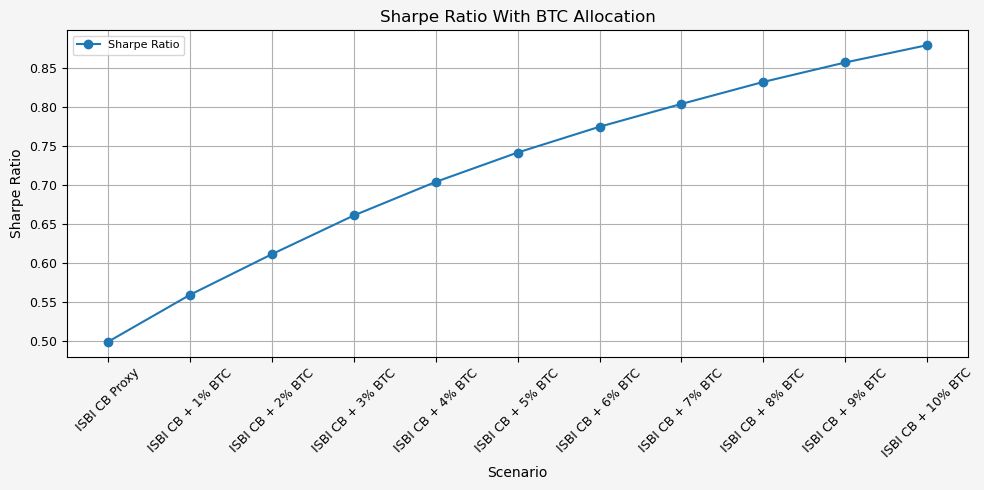

In [70]:
# Plotting the percentage change
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

plt.plot(final_df['Sharpe Ratio'], label = 'Sharpe Ratio', marker='o', linestyle='-')

# Set X axis
plt.xlabel('Scenario')
plt.xticks(rotation = 45, fontsize = 9)

# Set Y axis
# plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage)) # Formatting y-axis as percentage
plt.ylabel('Sharpe Ratio')
plt.yticks(fontsize = 9)

# Set title, etc.
plt.title('Sharpe Ratio With BTC Allocation', fontsize = 12)

# Display the plot
plt.grid(True)
plt.legend(fontsize = 8)
plt.tight_layout()
plt.show()

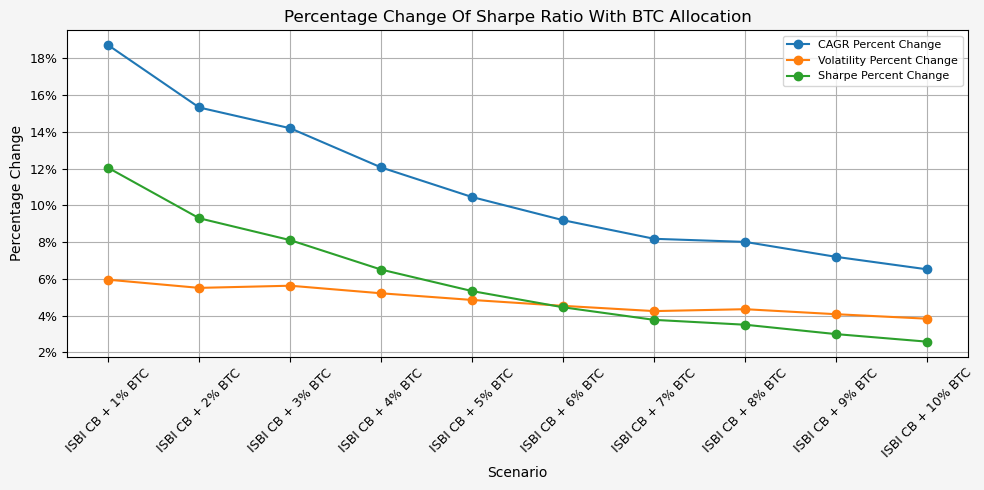

In [71]:
# Plotting the percentage change
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

plt.plot(final_df['CAGR Percent Change'], label = 'CAGR Percent Change', marker='o', linestyle='-')
plt.plot(final_df['Volatility Percent Change'], label = 'Volatility Percent Change', marker='o', linestyle='-')
plt.plot(final_df['Sharpe Percent Change'], label = 'Sharpe Percent Change', marker='o', linestyle='-')

# Set X axis
plt.xlabel('Scenario')
plt.xticks(rotation = 45, fontsize = 9)

# Set Y axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage)) # Formatting y-axis as percentage
plt.ylabel('Percentage Change')
plt.yticks(fontsize = 9)

# Set title, etc.
plt.title('Percentage Change Of Sharpe Ratio With BTC Allocation', fontsize = 12)

# Display the plot
plt.grid(True)
plt.legend(fontsize = 8)
plt.tight_layout()
plt.show()

## Cumulative Returns - BTC

In [72]:
cum_ret['ISBI CB Proxy Returns CR'] = (1 + cum_ret['ISBI CB Proxy Returns']).cumprod()
cum_ret['ISBI CB + 1% BTC CR'] = (1 + cum_ret['ISBI CB + 1% BTC']).cumprod()
cum_ret['ISBI CB + 2% BTC CR'] = (1 + cum_ret['ISBI CB + 2% BTC']).cumprod()
cum_ret['ISBI CB + 3% BTC CR'] = (1 + cum_ret['ISBI CB + 3% BTC']).cumprod()
cum_ret['ISBI CB + 4% BTC CR'] = (1 + cum_ret['ISBI CB + 4% BTC']).cumprod()
cum_ret['ISBI CB + 5% BTC CR'] = (1 + cum_ret['ISBI CB + 5% BTC']).cumprod()
cum_ret['ISBI CB + 6% BTC CR'] = (1 + cum_ret['ISBI CB + 6% BTC']).cumprod()
cum_ret['ISBI CB + 7% BTC CR'] = (1 + cum_ret['ISBI CB + 7% BTC']).cumprod()
cum_ret['ISBI CB + 8% BTC CR'] = (1 + cum_ret['ISBI CB + 8% BTC']).cumprod()
cum_ret['ISBI CB + 9% BTC CR'] = (1 + cum_ret['ISBI CB + 9% BTC']).cumprod()
cum_ret['ISBI CB + 10% BTC CR'] = (1 + cum_ret['ISBI CB + 10% BTC']).cumprod()
# cum_ret = cum_ret[['ISBI CB Proxy Returns CR', 'ISBI CB + 3% BTC CR', 'ISBI CB + 5% BTC CR', 'ISBI CB + 7% BTC CR', 'ISBI CB + 10% BTC CR']]

In [73]:
cum_ret

,ISBI CB + 1% BTC,ISBI CB + 2% BTC,ISBI CB + 3% BTC,ISBI CB + 4% BTC,ISBI CB + 5% BTC,ISBI CB + 6% BTC,ISBI CB + 7% BTC,ISBI CB + 8% BTC,ISBI CB + 9% BTC,ISBI CB + 10% BTC,...,ISBI CB + 1% BTC CR,ISBI CB + 2% BTC CR,ISBI CB + 3% BTC CR,ISBI CB + 4% BTC CR,ISBI CB + 5% BTC CR,ISBI CB + 6% BTC CR,ISBI CB + 7% BTC CR,ISBI CB + 8% BTC CR,ISBI CB + 9% BTC CR,ISBI CB + 10% BTC CR
FY 2016,0.024,0.039,0.055,0.071,0.086,0.102,0.116,0.132,0.148,0.163,...,1.024,1.039,1.055,1.071,1.086,1.102,1.116,1.132,1.148,1.163
FY 2017,0.152,0.177,0.203,0.230,0.255,0.280,0.305,0.331,0.357,0.382,...,1.179,1.222,1.269,1.317,1.364,1.410,1.457,1.507,1.558,1.608
FY 2018,0.070,0.085,0.101,0.116,0.132,0.147,0.161,0.177,0.192,0.207,...,1.262,1.326,1.397,1.470,1.543,1.617,1.692,1.774,1.857,1.941
FY 2019,0.067,0.073,0.080,0.086,0.093,0.099,0.105,0.111,0.117,0.124,...,1.346,1.423,1.509,1.597,1.686,1.777,1.869,1.972,2.076,2.181
FY 2020,-0.000,-0.002,-0.003,-0.005,-0.007,-0.008,-0.010,-0.011,-0.013,-0.014,...,1.346,1.420,1.504,1.589,1.675,1.763,1.851,1.950,2.049,2.150
FY 2021,0.261,0.286,0.313,0.340,0.366,0.392,0.417,0.443,0.469,0.495,...,1.697,1.827,1.975,2.129,2.288,2.453,2.623,2.814,3.011,3.214
FY 2022,-0.076,-0.080,-0.083,-0.087,-0.091,-0.094,-0.098,-0.101,-0.105,-0.109,...,1.568,1.682,1.811,1.944,2.081,2.222,2.366,2.528,2.695,2.865
FY 2023,0.055,0.059,0.065,0.070,0.075,0.079,0.084,0.089,0.094,0.099,...,1.654,1.782,1.928,2.079,2.236,2.398,2.565,2.754,2.948,3.148


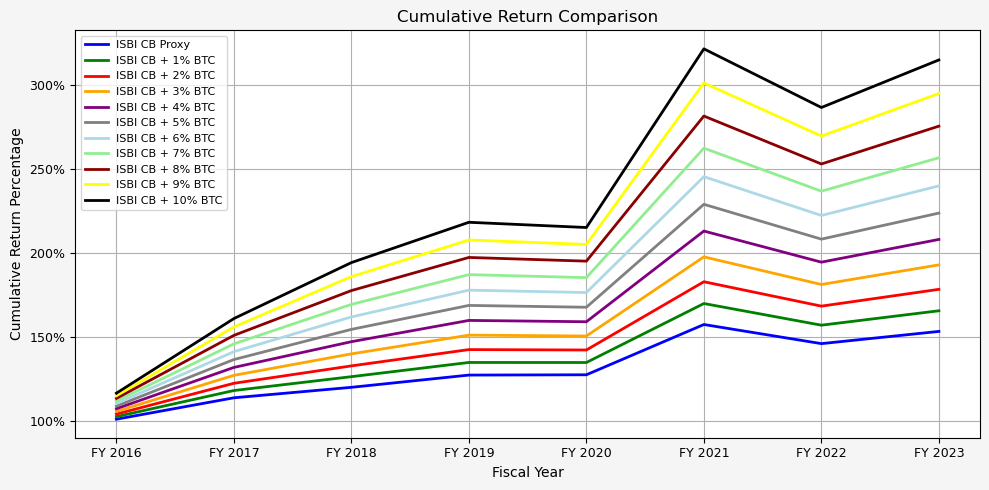

In [74]:
# Create the initial plot
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

# Plot the data
plt.plot(cum_ret.index, cum_ret['ISBI CB Proxy Returns CR'], label = 'ISBI CB Proxy', linestyle='-', color='b', linewidth=2)
plt.plot(cum_ret.index, cum_ret['ISBI CB + 1% BTC CR'], label = 'ISBI CB + 1% BTC', linestyle='-', color='g', linewidth=2)
plt.plot(cum_ret.index, cum_ret['ISBI CB + 2% BTC CR'], label = 'ISBI CB + 2% BTC', linestyle='-', color='r', linewidth=2)
plt.plot(cum_ret.index, cum_ret['ISBI CB + 3% BTC CR'], label = 'ISBI CB + 3% BTC', linestyle='-', color='orange', linewidth=2)
plt.plot(cum_ret.index, cum_ret['ISBI CB + 4% BTC CR'], label = 'ISBI CB + 4% BTC', linestyle='-', color='purple', linewidth=2)
plt.plot(cum_ret.index, cum_ret['ISBI CB + 5% BTC CR'], label = 'ISBI CB + 5% BTC', linestyle='-', color='gray', linewidth=2)
plt.plot(cum_ret.index, cum_ret['ISBI CB + 6% BTC CR'], label = 'ISBI CB + 6% BTC', linestyle='-', color='lightblue', linewidth=2)
plt.plot(cum_ret.index, cum_ret['ISBI CB + 7% BTC CR'], label = 'ISBI CB + 7% BTC', linestyle='-', color='lightgreen', linewidth=2)
plt.plot(cum_ret.index, cum_ret['ISBI CB + 8% BTC CR'], label = 'ISBI CB + 8% BTC', linestyle='-', color='darkred', linewidth=2)
plt.plot(cum_ret.index, cum_ret['ISBI CB + 9% BTC CR'], label = 'ISBI CB + 9% BTC', linestyle='-', color='yellow', linewidth=2)
plt.plot(cum_ret.index, cum_ret['ISBI CB + 10% BTC CR'], label = 'ISBI CB + 10% BTC', linestyle='-', color='black', linewidth=2)

# Set X axis
plt.xlabel('Fiscal Year')
plt.xticks(rotation = 0, fontsize = 9)

# Set Y axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage)) # Formatting y-axis as percentage
plt.ylabel('Cumulative Return Percentage')
plt.yticks(fontsize = 9)

# Set title, etc.
plt.title('Cumulative Return Comparison', fontsize = 12)
plt.tight_layout()
plt.legend(fontsize = 8)
plt.grid(True)
plt.show()

## Mean Variance Optimization - BTC

In [84]:
all_fund_mon_ret = iwv.copy()
all_fund_mon_ret['IWV'] = all_fund_mon_ret['adj_close'].pct_change()
all_fund_mon_ret.drop(columns = {'adj_close'}, inplace = True)

index_dfs = [(efa, 'EFA'), (eem, 'EEM'), (acwx, 'ACWX'), (agg, 'AGG'), (spti, 'SPTI'), (vglt, 'VGLT'), (tip, 'TIP'), 
             (LF98TRUU, 'LF98TRUU'), (SPBDLLB, 'SPBDLLB'), (NPPI0DIV, 'NPPI0DIV'), (LPX50TR, 'LPX50TR'),
             (emb, 'EMB'), (hdg, 'HDG'),(psp, 'PSP'), (cpi, 'CPI'), (gsg, 'GSG'), (gld, 'GLD'), (btc, 'BTC')]

# index_dfs = [(efa, 'iShares MSCI EAFE ETF (EFA)'),
#              (eem, 'iShares MSCI Emerging Markets ETF (EEM)'), 
#              (acwx, 'iShares MSCI ACWI ex U.S. ETF (ACWX)'), 
#              (agg, 'US Aggregate Bond (AGG)'), 
#              (spti, 'SPDR Portfolio Intermediate Term Treasury ETF (SPTI)'),
#              (vglt, 'Vanguard Long-Term Treasury ETF (VGLT)'),
#              (tip, 'iShares TIPS Bond ETF (TIP)'), 
#              (LF98TRUU, 'Bloomberg US Corp HY TR Index (LF98TRUU)'),
#              (SPBDLLB, 'Morningstar LSTA US Leveraged Loan 100 Index (SPBDLLB)'), 
#              (NPPI0DIV, 'NCREIF Fund Index Open End Diversified Core (NPPI0DIV)'),
#              (LPX50TR, 'LPX Listed Private Equity Index TR (LPX50TR)'),
#              (emb, 'iShares J.P. Morgan USD Emerging Markets Bond ETF (EMB)'),
#              (hdg, 'ProShares Hedge Replication ETF (HDG)'),
#              (psp, 'Invesco Global Listed Private Equity ETF (PSP)'), 
#              (cpi, 'CPI'), 
#              (gsg, 'iShares S&P GSCI Commodity-Indexed Trust (GSG)'), 
#              (gld, 'SPDR Gold Shares ETF (GLD)'), 
#              (btc, 'Bitcoin Total Return (BTCUSD)')]

for df, name in index_dfs:
    corr_df = df.copy()
    corr_df[name] = corr_df['adj_close'].pct_change()
    corr_df.drop(columns = {'adj_close'}, inplace = True)
    try:
        corr_df.drop(columns = {'adj_close_orig'}, inplace = True)
    except:
        pass
    all_fund_mon_ret = pd.merge(all_fund_mon_ret, corr_df, left_on = 'Date', right_on = 'Date')

year = 'FY 2023'

cbm_weights_mod_mvo = cbm_weights_mod.copy()
# cbm_weights_mod_mvo.drop(columns = {'Asset Class', 'Fund Index', 'Proxy Index'}, inplace = True)
cbm_weights_mod_mvo = cbm_weights_mod_mvo[[year]]
cbm_weights_mod_mvo = cbm_weights_mod_mvo[cbm_weights_mod_mvo[year] != 0]

all_fund_mon_ret_mvo = all_fund_mon_ret.copy()
columns_to_keep = cbm_weights_mod_mvo.index
all_fund_mon_ret_mvo_filtered = all_fund_mon_ret_mvo.loc[:, all_fund_mon_ret_mvo.columns.isin(columns_to_keep)]
all_fund_mon_ret_mvo_filtered

,IWV,EFA,EEM,AGG,SPTI,VGLT,TIP,LF98TRUU,SPBDLLB,NPPI0DIV,LPX50TR,CPI,BTC
Date,,,,,,,,,,,,,
2014-09-30,-0.021,-0.039,-0.078,-0.006,-0.004,-0.020,-0.026,-0.021,-0.013,0.011,-0.020,0.000,NaN
2014-10-31,0.027,-0.003,0.014,0.009,0.006,0.025,0.009,0.012,0.002,0.011,0.028,-0.000,-0.126
2014-11-30,0.025,0.001,-0.015,0.008,0.004,0.027,0.002,-0.007,0.000,0.011,-0.016,-0.002,0.117
2014-12-31,-0.000,-0.040,-0.040,0.001,-0.004,0.031,-0.011,-0.014,-0.019,0.011,0.007,-0.003,-0.153
2015-01-31,-0.027,0.006,-0.007,0.021,0.016,0.087,0.032,0.007,0.001,0.011,0.041,-0.006,-0.321
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,-0.024,-0.031,-0.076,-0.029,-0.027,-0.047,-0.014,-0.013,-0.005,-0.017,-0.096,0.004,0.000
2023-03-31,0.024,0.031,0.032,0.024,0.028,0.047,0.029,0.011,-0.008,-0.011,0.105,0.001,0.230
2023-04-30,0.011,0.029,-0.008,0.006,0.007,0.005,0.001,0.010,0.005,-0.011,0.021,0.004,0.028


In [85]:
returns_df = all_fund_mon_ret_mvo_filtered

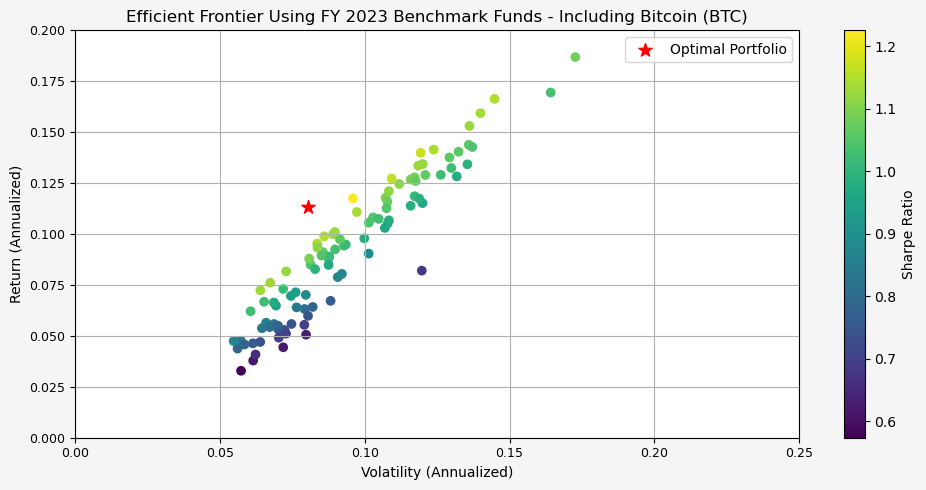

Optimal Weights: [0.19286008 0.01       0.01       0.2        0.01       0.01
 0.08947315 0.01       0.01       0.2        0.2        0.
 0.05766677]
Expected Annual Return: 0.11329316015286128
Expected Annual Volatility: 0.08039959720800045


In [86]:
import numpy as np
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called returns_df
# returns_df = pd.read_csv('path_to_your_file.csv')

# Calculate the mean returns and the covariance matrix
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

# Define the number of assets
num_assets = len(mean_returns)

# Function to calculate portfolio statistics
def portfolio_statistics(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights) * 12  # Annualize return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(12)  # Annualize volatility
    return portfolio_return, portfolio_volatility

# Function to minimize (negative Sharpe Ratio)
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_return, p_volatility = portfolio_statistics(weights, mean_returns, cov_matrix)
    return -(p_return - risk_free_rate) / p_volatility

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Define custom bounds for each asset
custom_bounds = [(0.01, 0.2) for asset in range(0, num_assets - 2)] + [(0, 0), (0.01, 0.2)]

# Initial guess (equal weights)
init_guess = num_assets * [1. / num_assets]

# Risk-free rate (assumed to be zero here, adjust as necessary)
risk_free_rate = 0.0

# Optimize the portfolio
opt_result = sco.minimize(negative_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix, risk_free_rate),
                          method='SLSQP', bounds=custom_bounds, constraints=constraints)

# Get the optimal weights
optimal_weights = opt_result.x

# Calculate the optimized portfolio statistics
optimized_return, optimized_volatility = portfolio_statistics(optimal_weights, mean_returns, cov_matrix)

# Generate portfolios for the efficient frontier
num_portfolios = 100
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    portfolio_return, portfolio_volatility = portfolio_statistics(weights, mean_returns, cov_matrix)
    results[0,i] = portfolio_volatility
    results[1,i] = portfolio_return
    results[2,i] = (portfolio_return - risk_free_rate) / portfolio_volatility

# Plot the Efficient Frontier
# Plotting the percentage change
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')

# Set X axis
plt.xlabel('Volatility (Annualized)')
plt.xticks(rotation = 0, fontsize = 9)
plt.xlim(0, 0.25)

# Set Y axis
plt.ylabel('Return (Annualized)')
plt.yticks(fontsize = 9)
plt.ylim(0, 0.20)


# Set title, etc.
plt.title('Efficient Frontier Using FY 2023 Benchmark Funds - Including Bitcoin (BTC)', fontsize = 12)
plt.scatter(optimized_volatility, optimized_return, marker='*', color='r', s=100, label='Optimal Portfolio')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.legend(loc='best')
plt.show()

# Print the results
print("Optimal Weights:", optimal_weights)
print("Expected Annual Return:", optimized_return)
print("Expected Annual Volatility:", optimized_volatility)

In [87]:
mvo_results = pd.DataFrame(optimal_weights, index = all_fund_mon_ret_mvo_filtered.columns)
mvo_results.rename(columns = {0: 'MVO Weights'}, inplace = True)
mvo_results

,MVO Weights
IWV,0.193
EFA,0.010
EEM,0.010
AGG,0.200
SPTI,0.010
VGLT,0.010
TIP,0.089
LF98TRUU,0.010
SPBDLLB,0.010
NPPI0DIV,0.200


## Mean Variance Optimization - Without BTC

In [88]:
all_fund_mon_ret = iwv.copy()
all_fund_mon_ret['IWV'] = all_fund_mon_ret['adj_close'].pct_change()
all_fund_mon_ret.drop(columns = {'adj_close'}, inplace = True)

index_dfs = [(efa, 'EFA'), (eem, 'EEM'), (acwx, 'ACWX'), (agg, 'AGG'), (spti, 'SPTI'), (vglt, 'VGLT'), (tip, 'TIP'), 
             (LF98TRUU, 'LF98TRUU'), (SPBDLLB, 'SPBDLLB'), (NPPI0DIV, 'NPPI0DIV'), (LPX50TR, 'LPX50TR'),
             (emb, 'EMB'), (hdg, 'HDG'),(psp, 'PSP'), (cpi, 'CPI'), (gsg, 'GSG'), (gld, 'GLD'), (btc, 'BTC')]

# index_dfs = [(efa, 'iShares MSCI EAFE ETF (EFA)'),
#              (eem, 'iShares MSCI Emerging Markets ETF (EEM)'), 
#              (acwx, 'iShares MSCI ACWI ex U.S. ETF (ACWX)'), 
#              (agg, 'US Aggregate Bond (AGG)'), 
#              (spti, 'SPDR Portfolio Intermediate Term Treasury ETF (SPTI)'),
#              (vglt, 'Vanguard Long-Term Treasury ETF (VGLT)'),
#              (tip, 'iShares TIPS Bond ETF (TIP)'), 
#              (LF98TRUU, 'Bloomberg US Corp HY TR Index (LF98TRUU)'),
#              (SPBDLLB, 'Morningstar LSTA US Leveraged Loan 100 Index (SPBDLLB)'), 
#              (NPPI0DIV, 'NCREIF Fund Index Open End Diversified Core (NPPI0DIV)'),
#              (LPX50TR, 'LPX Listed Private Equity Index TR (LPX50TR)'),
#              (emb, 'iShares J.P. Morgan USD Emerging Markets Bond ETF (EMB)'),
#              (hdg, 'ProShares Hedge Replication ETF (HDG)'),
#              (psp, 'Invesco Global Listed Private Equity ETF (PSP)'), 
#              (cpi, 'CPI'), 
#              (gsg, 'iShares S&P GSCI Commodity-Indexed Trust (GSG)'), 
#              (gld, 'SPDR Gold Shares ETF (GLD)'), 
#              (btc, 'Bitcoin Total Return (BTCUSD)')]

for df, name in index_dfs:
    corr_df = df.copy()
    corr_df[name] = corr_df['adj_close'].pct_change()
    corr_df.drop(columns = {'adj_close'}, inplace = True)
    try:
        corr_df.drop(columns = {'adj_close_orig'}, inplace = True)
    except:
        pass
    all_fund_mon_ret = pd.merge(all_fund_mon_ret, corr_df, left_on = 'Date', right_on = 'Date')

year = 'FY 2023'

cbm_weights_mvo = cbm_weights.copy()
cbm_weights_mvo.drop(columns = {'Asset Class', 'Fund Index', 'Proxy Index'}, inplace = True)
cbm_weights_mvo = cbm_weights_mvo[[year]]
cbm_weights_mvo = cbm_weights_mvo[cbm_weights_mvo[year] != 0]

all_fund_mon_ret_mvo = all_fund_mon_ret.copy()
columns_to_keep = cbm_weights_mvo.index
all_fund_mon_ret_mvo_filtered = all_fund_mon_ret_mvo.loc[:, all_fund_mon_ret_mvo.columns.isin(columns_to_keep)]
all_fund_mon_ret_mvo_filtered

,IWV,EFA,EEM,AGG,SPTI,VGLT,TIP,LF98TRUU,SPBDLLB,NPPI0DIV,LPX50TR,CPI
Date,,,,,,,,,,,,
2014-09-30,-0.021,-0.039,-0.078,-0.006,-0.004,-0.020,-0.026,-0.021,-0.013,0.011,-0.020,0.000
2014-10-31,0.027,-0.003,0.014,0.009,0.006,0.025,0.009,0.012,0.002,0.011,0.028,-0.000
2014-11-30,0.025,0.001,-0.015,0.008,0.004,0.027,0.002,-0.007,0.000,0.011,-0.016,-0.002
2014-12-31,-0.000,-0.040,-0.040,0.001,-0.004,0.031,-0.011,-0.014,-0.019,0.011,0.007,-0.003
2015-01-31,-0.027,0.006,-0.007,0.021,0.016,0.087,0.032,0.007,0.001,0.011,0.041,-0.006
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,-0.024,-0.031,-0.076,-0.029,-0.027,-0.047,-0.014,-0.013,-0.005,-0.017,-0.096,0.004
2023-03-31,0.024,0.031,0.032,0.024,0.028,0.047,0.029,0.011,-0.008,-0.011,0.105,0.001
2023-04-30,0.011,0.029,-0.008,0.006,0.007,0.005,0.001,0.010,0.005,-0.011,0.021,0.004


In [89]:
returns_df = all_fund_mon_ret_mvo_filtered

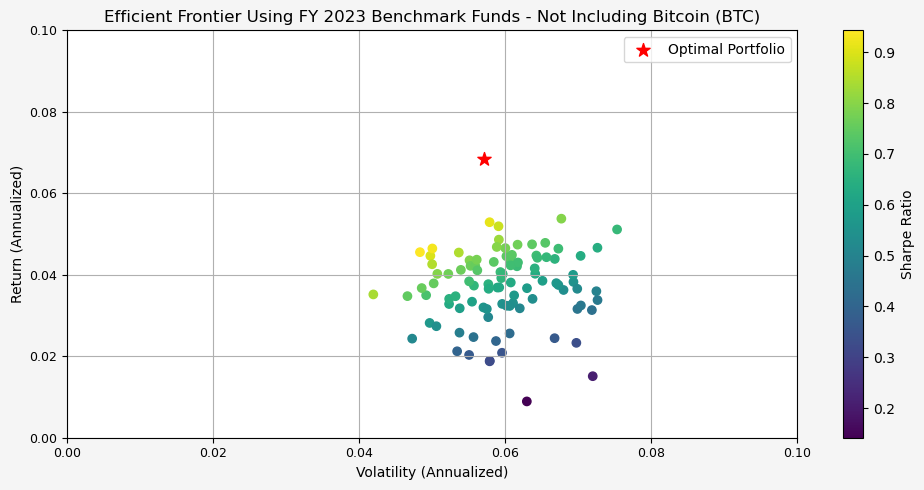

Optimal Weights: [0.2        0.01       0.01       0.2        0.01       0.01
 0.10756707 0.06542661 0.01       0.2        0.17700632 0.        ]
Expected Annual Return: 0.06839336519658981
Expected Annual Volatility: 0.05705027760010963


In [90]:
import numpy as np
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called returns_df
# returns_df = pd.read_csv('path_to_your_file.csv')

# Calculate the mean returns and the covariance matrix
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

# Define the number of assets
num_assets = len(mean_returns)

# Function to calculate portfolio statistics
def portfolio_statistics(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(mean_returns * weights) * 12  # Annualize return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(12)  # Annualize volatility
    return portfolio_return, portfolio_volatility

# Function to minimize (negative Sharpe Ratio)
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_return, p_volatility = portfolio_statistics(weights, mean_returns, cov_matrix)
    return -(p_return - risk_free_rate) / p_volatility

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Define custom bounds for each asset
custom_bounds = [(0.01, 0.2) for asset in range(0, num_assets - 1)] + [(0, 0)]

# Initial guess (equal weights)
init_guess = num_assets * [1. / num_assets]

# Risk-free rate (assumed to be zero here, adjust as necessary)
risk_free_rate = 0.0

# Optimize the portfolio
opt_result = sco.minimize(negative_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix, risk_free_rate),
                          method='SLSQP', bounds=custom_bounds, constraints=constraints)

# Get the optimal weights
optimal_weights = opt_result.x

# Calculate the optimized portfolio statistics
optimized_return, optimized_volatility = portfolio_statistics(optimal_weights, mean_returns, cov_matrix)

# Generate portfolios for the efficient frontier
num_portfolios = 100
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    portfolio_return, portfolio_volatility = portfolio_statistics(weights, mean_returns, cov_matrix)
    results[0,i] = portfolio_volatility
    results[1,i] = portfolio_return
    results[2,i] = (portfolio_return - risk_free_rate) / portfolio_volatility

# Plot the Efficient Frontier
# Plotting the percentage change
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')

# Set X axis
plt.xlabel('Volatility (Annualized)')
plt.xticks(rotation = 0, fontsize = 9)
plt.xlim(0, 0.1)

# Set Y axis
plt.ylabel('Return (Annualized)')
plt.yticks(fontsize = 9)
plt.ylim(0, 0.1)


# Set title, etc.
plt.title('Efficient Frontier Using FY 2023 Benchmark Funds - Not Including Bitcoin (BTC)', fontsize = 12)
plt.scatter(optimized_volatility, optimized_return, marker='*', color='r', s=100, label='Optimal Portfolio')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.legend(loc='best')
plt.show()

# Print the results
print("Optimal Weights:", optimal_weights)
print("Expected Annual Return:", optimized_return)
print("Expected Annual Volatility:", optimized_volatility)

In [91]:
mvo_results = pd.DataFrame(optimal_weights, index = all_fund_mon_ret_mvo_filtered.columns)
mvo_results.rename(columns = {0: 'MVO Weights'}, inplace = True)
mvo_results

,MVO Weights
IWV,0.200
EFA,0.010
EEM,0.010
AGG,0.200
SPTI,0.010
VGLT,0.010
TIP,0.108
LF98TRUU,0.065
SPBDLLB,0.010
NPPI0DIV,0.200


In [92]:
x = pd.DataFrame()
x.at['MVO Without BTC', 'Expected Return'] = 0.06839336519658981
x.at['MVO Without BTC', 'Expected Volatility'] = 0.05705027760010963
x.at['MVO With BTC', 'Expected Return'] = 0.11329316015286128
x.at['MVO With BTC', 'Expected Volatility'] = 0.08039959720800045

x['Sharpe Ratio'] = x['Expected Return'] / x['Expected Volatility']

In [93]:
x

,Expected Return,Expected Volatility,Sharpe Ratio
MVO Without BTC,0.068,0.057,1.199
MVO With BTC,0.113,0.080,1.409


## BTC Cumulative Returns

In [97]:
btc_ret = all_fund_mon_ret[['BTC']]
btc_ret['cum_ret'] = (1 + btc_ret['BTC']).cumprod()
btc_ret

,BTC,cum_ret
Date,,
2014-09-30,NaN,NaN
2014-10-31,-0.126,0.874
2014-11-30,0.117,0.977
2014-12-31,-0.153,0.827
2015-01-31,-0.321,0.562
...,...,...
2023-02-28,0.000,59.821
2023-03-31,0.230,73.598
2023-04-30,0.028,75.641


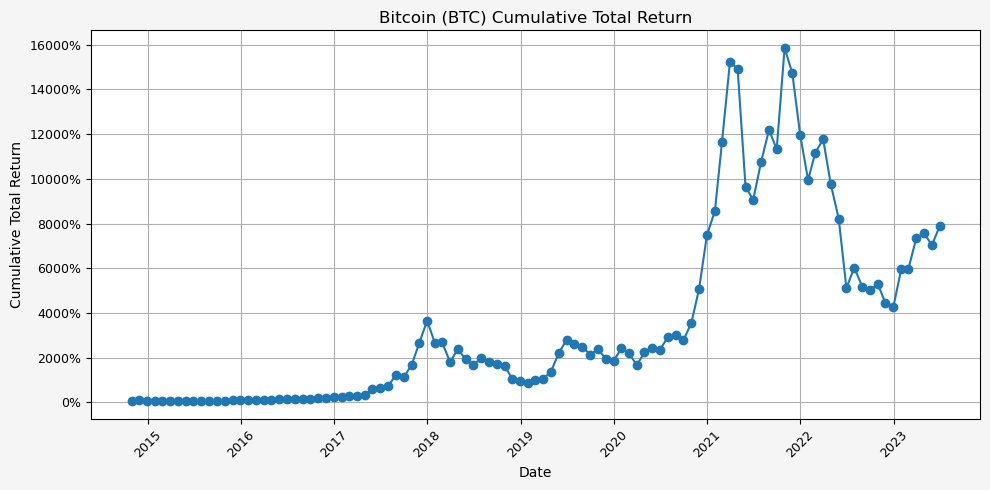

In [98]:
# Create the initial plot
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

plt.plot(btc_ret['cum_ret'], label = 'BTC Cumulative Return', marker='o', linestyle='-')

# Set X axis
plt.xlabel('Date')
plt.xticks(rotation = 45, fontsize = 9)

# Set Y axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage)) # Formatting y-axis as percentage
plt.ylabel('Cumulative Total Return')
plt.yticks(fontsize = 9)

# Set title, etc.
plt.title('Bitcoin (BTC) Cumulative Total Return', fontsize = 12)

# Display the plot
plt.grid(True)
# plt.legend(fontsize = 8)
plt.tight_layout()
plt.show()

    
   

## BTC Drawdown

In [99]:
btc_ret['cum_ret']

Date
2014-09-30      NaN
2014-10-31    0.874
2014-11-30    0.977
2014-12-31    0.827
2015-01-31    0.562
              ...  
2023-02-28   59.821
2023-03-31   73.598
2023-04-30   75.641
2023-05-31   70.345
2023-06-30   78.764
Name: cum_ret, Length: 106, dtype: float64

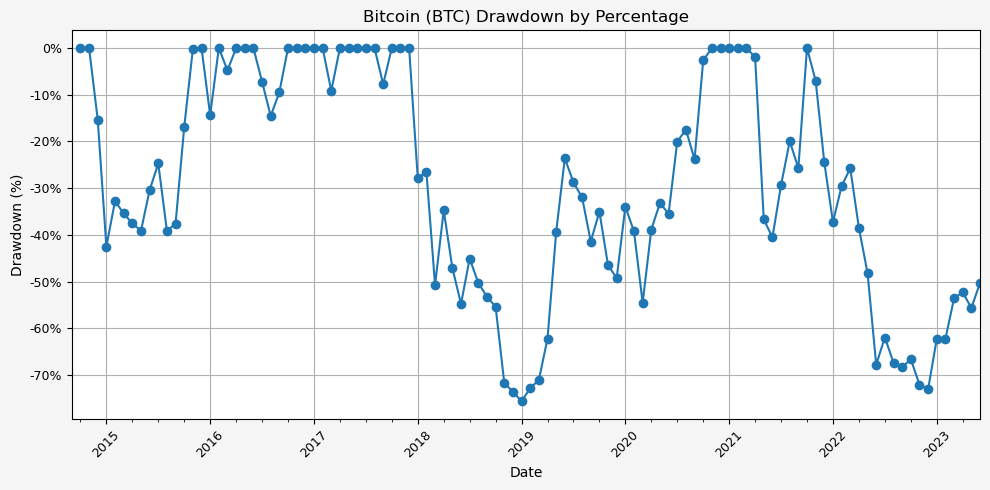

In [100]:
rolling_max = btc_ret['cum_ret'].cummax()
drawdown = (btc_ret['cum_ret'] - rolling_max) / rolling_max

# Plotting the percentage change
plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

drawdown.plot(marker='o', linestyle='-')

# Set X axis
plt.xlabel('Date')
plt.xticks(rotation = 45, fontsize = 9)

# Set Y axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage)) # Formatting y-axis as percentage
plt.ylabel('Drawdown (%)')
plt.yticks(fontsize = 9)

# Set title, etc.
plt.title('Bitcoin (BTC) Drawdown by Percentage', fontsize = 12)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

## Correlations

In [101]:
all_fund_mon_ret = iwv.copy()
all_fund_mon_ret['iShares Russell 3000 ETF (IWV)'] = all_fund_mon_ret['adj_close'].pct_change()
all_fund_mon_ret.drop(columns = {'adj_close'}, inplace = True)

# index_dfs = [(efa, 'EFA'), (eem, 'EEM'), (acwx, 'ACWX'), (agg, 'AGG'), (spti, 'SPTI'), (vglt, 'VGLT'), (tip, 'TIP'), 
#              (LF98TRUU, 'LF98TRUU'), (SPBDLLB, 'SPBDLLB'), (NPPI0DIV, 'NPPI0DIV'), (LPX50TR, 'LPX50TR'),
#              (emb, 'EMB'), (hdg, 'HDG'),(psp, 'PSP'), (cpi, 'CPI'), (gsg, 'GSG'), (gld, 'GLD'), (btc, 'BTC')]

index_dfs = [(efa, 'iShares MSCI EAFE ETF (EFA)'),
             (eem, 'iShares MSCI Emerging Markets ETF (EEM)'), 
             (acwx, 'iShares MSCI ACWI ex U.S. ETF (ACWX)'), 
             (agg, 'US Aggregate Bond (AGG)'), 
             (spti, 'SPDR Portfolio Intermediate Term Treasury ETF (SPTI)'),
             (vglt, 'Vanguard Long-Term Treasury ETF (VGLT)'),
             (tip, 'iShares TIPS Bond ETF (TIP)'), 
             (LF98TRUU, 'Bloomberg US Corp HY TR Index (LF98TRUU)'),
             (SPBDLLB, 'Morningstar LSTA US Leveraged Loan 100 Index (SPBDLLB)'), 
             (NPPI0DIV, 'NCREIF Fund Index Open End Diversified Core (NPPI0DIV)'),
             (LPX50TR, 'LPX Listed Private Equity Index TR (LPX50TR)'),
             (emb, 'iShares J.P. Morgan USD Emerging Markets Bond ETF (EMB)'),
             (hdg, 'ProShares Hedge Replication ETF (HDG)'),
             (psp, 'Invesco Global Listed Private Equity ETF (PSP)'), 
             (cpi, 'CPI'), 
             (gsg, 'iShares S&P GSCI Commodity-Indexed Trust (GSG)'), 
             (gld, 'SPDR Gold Shares ETF (GLD)'), 
             (btc, 'Bitcoin Total Return (BTCUSD)')]

for df, name in index_dfs:
    corr_df = df.copy()
    corr_df[name] = corr_df['adj_close'].pct_change()
    corr_df.drop(columns = {'adj_close'}, inplace = True)
    try:
        corr_df.drop(columns = {'adj_close_orig'}, inplace = True)
    except:
        pass
    all_fund_mon_ret = pd.merge(all_fund_mon_ret, corr_df, left_on = 'Date', right_on = 'Date')

all_fund_mon_ret.columns

Index(['iShares Russell 3000 ETF (IWV)', 'iShares MSCI EAFE ETF (EFA)',
       'iShares MSCI Emerging Markets ETF (EEM)',
       'iShares MSCI ACWI ex U.S. ETF (ACWX)', 'US Aggregate Bond (AGG)',
       'SPDR Portfolio Intermediate Term Treasury ETF (SPTI)',
       'Vanguard Long-Term Treasury ETF (VGLT)', 'iShares TIPS Bond ETF (TIP)',
       'Bloomberg US Corp HY TR Index (LF98TRUU)',
       'Morningstar LSTA US Leveraged Loan 100 Index (SPBDLLB)',
       'NCREIF Fund Index Open End Diversified Core (NPPI0DIV)',
       'LPX Listed Private Equity Index TR (LPX50TR)',
       'iShares J.P. Morgan USD Emerging Markets Bond ETF (EMB)',
       'ProShares Hedge Replication ETF (HDG)',
       'Invesco Global Listed Private Equity ETF (PSP)', 'CPI',
       'iShares S&P GSCI Commodity-Indexed Trust (GSG)',
       'SPDR Gold Shares ETF (GLD)', 'Bitcoin Total Return (BTCUSD)'],
      dtype='object')

In [102]:
all_fund_mon_ret = all_fund_mon_ret[all_fund_mon_ret.index >= '2015-06-30']
display(all_fund_mon_ret.head(1))
display(all_fund_mon_ret.tail(1))

,iShares Russell 3000 ETF (IWV),iShares MSCI EAFE ETF (EFA),iShares MSCI Emerging Markets ETF (EEM),iShares MSCI ACWI ex U.S. ETF (ACWX),US Aggregate Bond (AGG),SPDR Portfolio Intermediate Term Treasury ETF (SPTI),Vanguard Long-Term Treasury ETF (VGLT),iShares TIPS Bond ETF (TIP),Bloomberg US Corp HY TR Index (LF98TRUU),Morningstar LSTA US Leveraged Loan 100 Index (SPBDLLB),NCREIF Fund Index Open End Diversified Core (NPPI0DIV),LPX Listed Private Equity Index TR (LPX50TR),iShares J.P. Morgan USD Emerging Markets Bond ETF (EMB),ProShares Hedge Replication ETF (HDG),Invesco Global Listed Private Equity ETF (PSP),CPI,iShares S&P GSCI Commodity-Indexed Trust (GSG),SPDR Gold Shares ETF (GLD),Bitcoin Total Return (BTCUSD)
Date,,,,,,,,,,,,,,,,,,,
2015-06-30,-0.017,-0.031,-0.029,-0.032,-0.011,-0.006,-0.036,-0.010,-0.015,-0.014,0.013,-0.005,-0.018,-0.008,-0.052,0.003,-0.002,-0.015,0.143


,iShares Russell 3000 ETF (IWV),iShares MSCI EAFE ETF (EFA),iShares MSCI Emerging Markets ETF (EEM),iShares MSCI ACWI ex U.S. ETF (ACWX),US Aggregate Bond (AGG),SPDR Portfolio Intermediate Term Treasury ETF (SPTI),Vanguard Long-Term Treasury ETF (VGLT),iShares TIPS Bond ETF (TIP),Bloomberg US Corp HY TR Index (LF98TRUU),Morningstar LSTA US Leveraged Loan 100 Index (SPBDLLB),NCREIF Fund Index Open End Diversified Core (NPPI0DIV),LPX Listed Private Equity Index TR (LPX50TR),iShares J.P. Morgan USD Emerging Markets Bond ETF (EMB),ProShares Hedge Replication ETF (HDG),Invesco Global Listed Private Equity ETF (PSP),CPI,iShares S&P GSCI Commodity-Indexed Trust (GSG),SPDR Gold Shares ETF (GLD),Bitcoin Total Return (BTCUSD)
Date,,,,,,,,,,,,,,,,,,,
2023-06-30,0.068,0.045,0.044,0.046,-0.004,-0.013,0.000,-0.003,0.017,0.018,-0.009,0.013,0.025,0.017,0.047,0.002,0.044,-0.022,0.120


MIN Correlation pair is ('Vanguard Long-Term Treasury ETF (VGLT)', 'iShares S&P GSCI Commodity-Indexed Trust (GSG)')
MAX Correlation pair is ('iShares MSCI EAFE ETF (EFA)', 'iShares MSCI ACWI ex U.S. ETF (ACWX)')


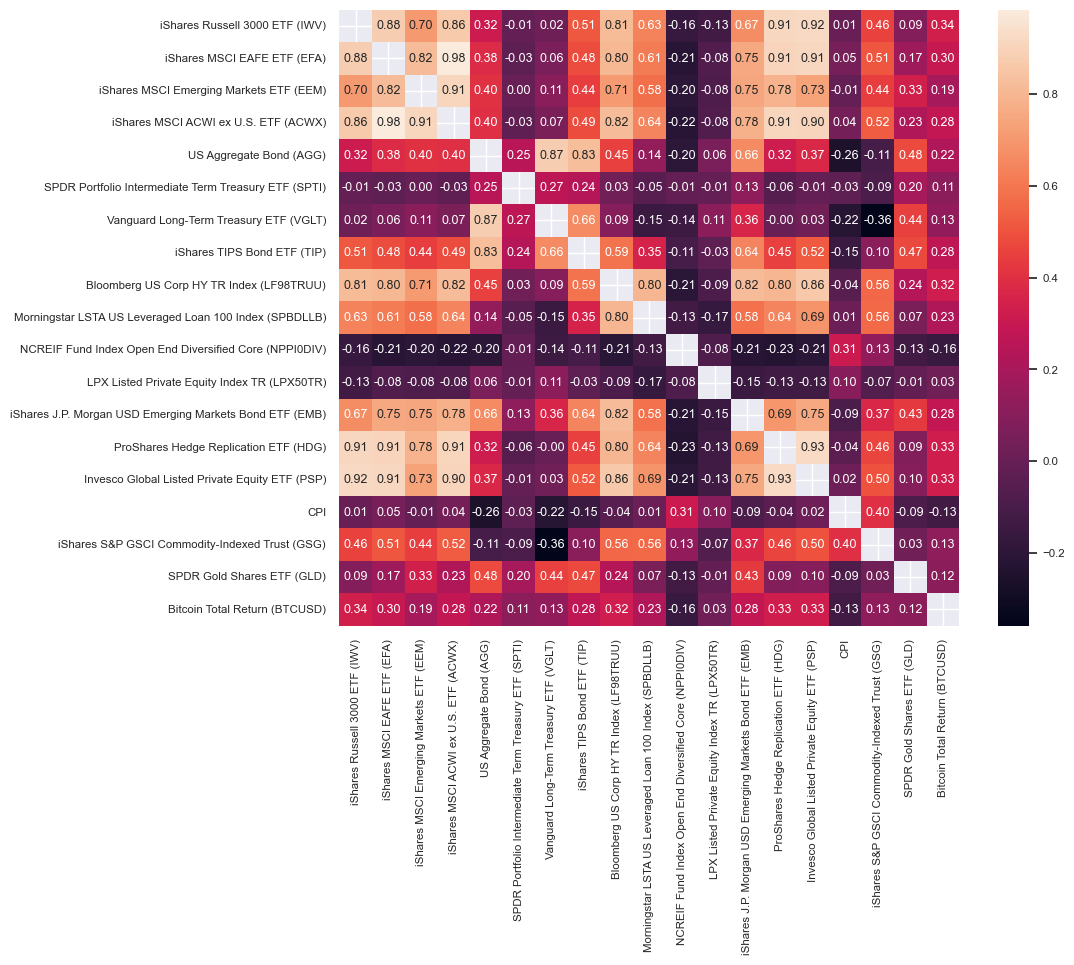

In [103]:
display_correlation(all_fund_mon_ret)